# Final Project_Analysis on Tweets of Obama

***By group 5: AMI SHAH, HUANG DENG, JAY JOSHI***

***Contents***  
**0. Importing Required Packages**  
**1. Scraping Tweets for Donald Trump**  
**2.1 Sentiment Analysis**  
2.11 Wordcloud for Donald Trump's tweets with positive sentiment  
2.12 Wordcloud for Donald Trump's tweets with negative sentiment  
**2.2 Topic Modelling**  
**3. Miscellaneous Methods for Data Visualization**  
3.1 Connection Web  
3.2 ScatterPlot for Linear Regression  
3.3 Bar Chart  
3.4 Time Series Graph  

# 0. Importing Required Packages

In [1]:
%pylab inline
import requests, re
import pandas as pd
import seaborn as sns
import nltk
pd.set_option('max_columns', 40)
pd.set_option('colwidth', 300)
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


# 1. Scraping Tweets for Barack Obama

In [ ]:
import twint
print ("Fetching Tweets")
c = twint.Config()
# choose username (optional)
c.Username = "BarackObama"
# choose search term (optional)
# c.Search = "insert search term here"
c.Search = "immigration OR emigration OR employment OR migration OR citizenship OR law OR immigrants OR in-migration OR deport OR deportation OR policy OR labour OR labor Or H1B OR visa OR PR OR work permit"
# no idea, but makes the csv format properly
c.Store_csv = True
# change the name of the csv file
c.Output = "tweets_test.csv"
twint.run.Search(c)

In [3]:
#file for Obama
df = pd.read_csv("tweets_test_Custom.csv") 

In [4]:
def standardize_report(pid, report='tweet'):
    # Print player information
    twt = df.loc[pid]
    print(twt['conversation_id'], twt['created_at'], twt['date'], twt['time'], twt['timezone'], twt['user_id'], '\n')
    
    # Extract report from player data frame
    s = df.at[pid, report]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,()]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords.words('english') if word != "he's"]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

In [5]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

# 2. 1 Sentiment Analysis

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
  
# function to print sentiments 
# of the sentence. 
def sentiment_scores(sentence): 
  
    # Create a SentimentIntensityAnalyzer object. 
    sid_obj = SentimentIntensityAnalyzer() 
  
    # polarity_scores method of SentimentIntensityAnalyzer 
    # oject gives a sentiment dictionary. 
    # which contains pos, neg, neu, and compound scores. 
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict

In [7]:
#calculating sentiment scores for each tweet and saving it as an extra column in our dataframe

sentiment_scores_list = []
pos_scores = []
neg_scores = []
neu_scores = []
compound_scores = []

for i in range(0, len(df)):
    sentiment_scores_list.append(sentiment_scores(df['tweet'][i]))
    pos_scores.append(sentiment_scores_list[i]['pos'])
    neg_scores.append(sentiment_scores_list[i]['neg'])
    neu_scores.append(sentiment_scores_list[i]['neu'])
    compound_scores.append(sentiment_scores_list[i]['compound'])
    
df['Positive_score'] = pos_scores
df['Negative_score'] = neg_scores
df['Neutral_score'] = neu_scores
df['Compound_score'] = compound_scores

In [8]:
#filtered_tweets = data[data['Compound_score'] <= -0.05 and data['Compound_score'] >= 0.05]

label=[]

for i in range(len(df)):
    if(df['Compound_score'][i]<=-0.05):
        
        label.append(0)
    elif(df['Compound_score'][i]>=0.05):
        label.append(1)
    else:
        label.append(2)

df['label']=label

### 2.11 Wordcloud for Donald Trump's tweets with positive sentiment

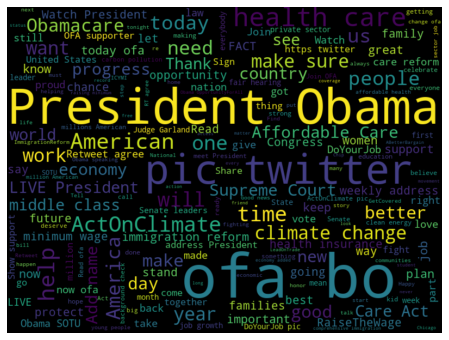

In [9]:
from wordcloud import WordCloud
positive_words=' '.join([text for text in df['tweet'][df['label']==1]])
wordcloud=WordCloud(width=800, height=600, random_state=21, max_font_size=110).generate(positive_words)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This word cloud shows that Trump has tweeted positively about law, healthcare, immigration, economy.

### 2.12 Wordcloud for Donald Trump's tweets with negative sentiment

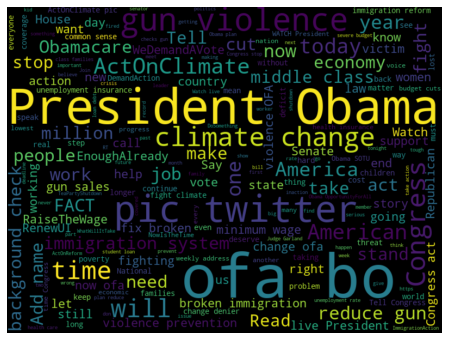

In [10]:
from wordcloud import WordCloud
negative_words=' '.join([text for text in df['tweet'][df['label']==0]])
wordcloud=WordCloud(width=800, height=600, random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

This word cloud shows that Obama has tweeted negatively about violence, immigration.

## 2.2 Topic Modelling 

In [11]:
#functioning for cleaning the tweets

def standardize_report(pid, report='tweet'):
    # Print player information
    twt = df.loc[pid]
    print(twt['conversation_id'], twt['created_at'], twt['date'], twt['time'], twt['timezone'], twt['user_id'], '\n')
    
    # Extract report from data frame
    s = df.at[pid, report]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)","",s).split())
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords.words('english') if word != "he's"]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

In [12]:
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

In [13]:
tweet_link_removed = []
tweet_user_removed = []
for i in range(0, len(df['tweet'])):
    tweet_link_removed.append(remove_links(df['tweet'][i]))
#     df['tweet_user_removed']=remove_users(i)
df_link=df
#del df_link['tweet_user_removed']
for i in range(0, len(df_link)):
    tweet_user_removed.append(remove_users(tweet_link_removed[i]))
df_link['tweet_user_removed'] = tweet_user_removed
df_link.head()               

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,Positive_score,Negative_score,Neutral_score,Compound_score,label,tweet_user_removed
0,1198664487089430529,1198663630117572609,1574618858000,2019-11-24,13:07:38,Eastern Standard Time,813286,barackobama,Barack Obama,NaN,"Politicians shouldn’t be picking their voters. Voters should be picking their representatives. But unless we act, the status quo will remain in states all across the country. Let's make sure maps are drawn fairly when redistricting happens again in 2021: https://allontheline.org/",[],['https://allontheline.org/'],[],623,5230,24948,[],[],https://twitter.com/BarackObama/status/1198664487089430529,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '813286', 'username': 'BarackObama'}]",NaN,0.069,0.000,0.931,0.4497,1,"Politicians shouldn’t be picking their voters. Voters should be picking their representatives. But unless we act, the status quo will remain in states all across the country. Let's make sure maps are drawn fairly when redistricting happens again in 2021:"
1,1198663630117572609,1198663630117572609,1574618654000,2019-11-24,13:04:14,Eastern Standard Time,813286,barackobama,Barack Obama,NaN,"Take a look at this piece to understand the very real consequences of gerrymandering. In Asheville, NC, we see what happens when district lines are drawn for maximum partisan advantage: It mean citizens’ voices are diminished. It means more polarization. https://www.cnn.com/2019/11/23/opinions/g...",[],['https://www.cnn.com/2019/11/23/opinions/gerrymandering-voting-districts-america-daley/index.html'],[],2099,17881,74561,[],[],https://twitter.com/BarackObama/status/1198663630117572609,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '813286', 'username': 'BarackObama'}]",NaN,0.049,0.000,0.951,0.2500,1,"Take a look at this piece to understand the very real consequences of gerrymandering. In Asheville, NC, we see what happens when district lines are drawn for maximum partisan advantage: It mean citizens’ voices are diminished. It means more polarization. …"
2,1197909838061359104,1197909838061359104,1574438936000,2019-11-22,11:08:56,Eastern Standard Time,813286,barackobama,Barack Obama,NaN,Young leaders like these are powering the promise of the Asia Pacific region. Michelle and I couldn’t be more impressed by their initiative. Can’t wait to join them in Malaysia next month. https://twitter.com/obamafoundation/status/1197530756337356801 …,[],['https://twitter.com/obamafoundation/status/1197530756337356801'],[],1356,4076,41492,[],[],https://twitter.com/BarackObama/status/1197909838061359104,False,https://twitter.com/ObamaFoundation/status/1197530756337356801,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '813286', 'username': 'BarackObama'}]",NaN,0.271,0.000,0.729,0.8553,1,Young leaders like these are powering the promise of the Asia Pacific region. Michelle and I couldn’t be more impressed by their initiative. Can’t wait to join them in Malaysia next month. …
3,1196498074660724736,1196498074660724736,1574102345000,2019-11-18,13:39:05,Eastern Standard Time,813286,barackobama,Barack Obama,NaN,"Proud to see Oluwaseun @AyodejiOsowobi in this list. She’s an @ObamaFoundation Leader who’s organizing young people in Nigeria to help end sexual violence, and her work embodies what our foundation is all about: passing the baton to the next generation. https://time.com/collection/time-100-next-...","['ayodejiosowobi', 'obamafoundation']",['https://time.com/collection/time-100-next-2019/5718899/oluwaseun-ayodeji-osowobi/'],[],1466,8252,47447,[],[],https://twitter.com/BarackObama/status/1196498074660724736,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '813286', 'username': 'BarackObama'}, {'user_id': '111579971', 'username': 'AyodejiOsowobi'}, {'user_id': '2293315159', 'username': '

In [14]:
obama_words = []

for pid in range(1, len(df)):
    obama_words = obama_words + (standardize_report(pid))
    
len(obama_words)

1198663630117572609 1574618654000 2019-11-24 13:04:14 Eastern Standard Time 813286 

1197909838061359104 1574438936000 2019-11-22 11:08:56 Eastern Standard Time 813286 

1196498074660724736 1574102345000 2019-11-18 13:39:05 Eastern Standard Time 813286 

1193899774182858752 1573482894000 2019-11-11 09:34:54 Eastern Standard Time 813286 

1193899774182858752 1573482862000 2019-11-11 09:34:22 Eastern Standard Time 813286 

1192844105631649792 1573231171000 2019-11-08 11:39:31 Eastern Standard Time 813286 

1192147846214160384 1573065170000 2019-11-06 13:32:50 Eastern Standard Time 813286 

1190630834736443393 1572703486000 2019-11-02 10:04:46 Eastern Standard Time 813286 

1190281354321317889 1572620163000 2019-11-01 10:56:03 Eastern Standard Time 813286 

1189903829589999618 1572530154000 2019-10-31 09:55:54 Eastern Standard Time 813286 

1188924481458331648 1572296660000 2019-10-28 17:04:20 Eastern Standard Time 813286 

1185207212085567488 1571410394000 2019-10-18 10:53:14 Eastern Sta

1096114852941234176 1550169120000 2019-02-14 13:32:00 Eastern Standard Time 813286 

1096066230442749952 1550157527000 2019-02-14 10:18:47 Eastern Standard Time 813286 

1095882980839616512 1550113837000 2019-02-13 22:10:37 Eastern Standard Time 813286 

1095492333481705472 1550020700000 2019-02-12 20:18:20 Eastern Standard Time 813286 

1093722143513346048 1549598654000 2019-02-07 23:04:14 Eastern Standard Time 813286 

1093721973824339968 1549598613000 2019-02-07 23:03:33 Eastern Standard Time 813286 

1091367581964034048 1549037282000 2019-02-01 11:08:02 Eastern Standard Time 813286 

1088863791058698240 1548440332000 2019-01-25 13:18:52 Eastern Standard Time 813286 

1087382991901474816 1548087282000 2019-01-21 11:14:42 Eastern Standard Time 813286 

1085915185146150912 1547737330000 2019-01-17 10:02:10 Eastern Standard Time 813286 

1080136459670175744 1546359574000 2019-01-01 11:19:34 Eastern Standard Time 813286 

1079048221861634048 1546100120000 2018-12-29 11:15:20 Eastern Sta

912724426709504000 1506445435000 2017-09-26 13:03:55 Eastern Standard Time 813286 

912460861758955523 1506382596000 2017-09-25 19:36:36 Eastern Standard Time 813286 

910330388219916290 1505874652000 2017-09-19 22:30:52 Eastern Standard Time 813286 

909871642423197696 1505765278000 2017-09-18 16:07:58 Eastern Standard Time 813286 

907969359695491072 1505311739000 2017-09-13 10:08:59 Eastern Standard Time 813286 

907265689832103936 1505143971000 2017-09-11 11:32:51 Eastern Standard Time 813286 

906269510231056385 1504906463000 2017-09-08 17:34:23 Eastern Standard Time 813286 

905930380783620097 1504825608000 2017-09-07 19:06:48 Eastern Standard Time 813286 

905141484386750469 1504637521000 2017-09-05 14:52:01 Eastern Standard Time 813286 

901946021437206528 1503875663000 2017-08-27 19:14:23 Eastern Standard Time 813286 

898261944095789056 1502997311000 2017-08-17 15:15:11 Eastern Standard Time 813286 

896523232098078720 1502582799000 2017-08-12 20:06:39 Eastern Standard Time 8

783781468719943680 1475703038000 2016-10-05 17:30:38 Eastern Standard Time 813286 

783769909146845184 1475700282000 2016-10-05 16:44:42 Eastern Standard Time 813286 

783751285212258304 1475695842000 2016-10-05 15:30:42 Eastern Standard Time 813286 

783695919006920704 1475682642000 2016-10-05 11:50:42 Eastern Standard Time 813286 

783404014054412288 1475613046000 2016-10-04 16:30:46 Eastern Standard Time 813286 

783373180861767681 1475605695000 2016-10-04 14:28:15 Eastern Standard Time 813286 

783349420951674880 1475600030000 2016-10-04 12:53:50 Eastern Standard Time 813286 

783322842955862020 1475593693000 2016-10-04 11:08:13 Eastern Standard Time 813286 

783009809356304385 1475519060000 2016-10-03 14:24:20 Eastern Standard Time 813286 

782966115248910337 1475508643000 2016-10-03 11:30:43 Eastern Standard Time 813286 

782230260767084545 1475333201000 2016-10-01 10:46:41 Eastern Standard Time 813286 

781970043894632448 1475271161000 2016-09-30 17:32:41 Eastern Standard Time 8

765957980541980672 1471453588000 2016-08-17 13:06:28 Eastern Standard Time 813286 

765936053400113153 1471448360000 2016-08-17 11:39:20 Eastern Standard Time 813286 

765621277251870720 1471373311000 2016-08-16 14:48:31 Eastern Standard Time 813286 

765587449959419904 1471365246000 2016-08-16 12:34:06 Eastern Standard Time 813286 

765561775257288704 1471359125000 2016-08-16 10:52:05 Eastern Standard Time 813286 

765289115847766017 1471294118000 2016-08-15 16:48:38 Eastern Standard Time 813286 

765259366308073473 1471287025000 2016-08-15 14:50:25 Eastern Standard Time 813286 

765233486701527040 1471280855000 2016-08-15 13:07:35 Eastern Standard Time 813286 

765209349882904576 1471275100000 2016-08-15 11:31:40 Eastern Standard Time 813286 

764536229920735232 1471114616000 2016-08-13 14:56:56 Eastern Standard Time 813286 

764517957045215232 1471110259000 2016-08-13 13:44:19 Eastern Standard Time 813286 

764218658319130624 1471038901000 2016-08-12 17:55:01 Eastern Standard Time 8

747474265176309760 1467046726000 2016-06-27 12:58:46 Eastern Standard Time 813286 

747226359211098112 1466987621000 2016-06-26 20:33:41 Eastern Standard Time 813286 

747209323303026688 1466983559000 2016-06-26 19:25:59 Eastern Standard Time 813286 

747190986183446528 1466979187000 2016-06-26 18:13:07 Eastern Standard Time 813286 

747174352274202624 1466975222000 2016-06-26 17:07:02 Eastern Standard Time 813286 

747152944047362049 1466970117000 2016-06-26 15:41:57 Eastern Standard Time 813286 

747124730126282752 1466963391000 2016-06-26 13:49:51 Eastern Standard Time 813286 

747066897917685760 1466949602000 2016-06-26 10:00:02 Eastern Standard Time 813286 

746815469726765056 1466889657000 2016-06-25 17:20:57 Eastern Standard Time 813286 

746783589312888832 1466882056000 2016-06-25 15:14:16 Eastern Standard Time 813286 

746481901075046405 1466810128000 2016-06-24 19:15:28 Eastern Standard Time 813286 

746450966183022593 1466802753000 2016-06-24 17:12:33 Eastern Standard Time 8

728579886663802880 1462541955000 2016-05-06 09:39:15 Eastern Standard Time 813286 

728331465419694081 1462482727000 2016-05-05 17:12:07 Eastern Standard Time 813286 

728301505183260673 1462475584000 2016-05-05 15:13:04 Eastern Standard Time 813286 

728271187889946624 1462468356000 2016-05-05 13:12:36 Eastern Standard Time 813286 

727984316878233600 1462399961000 2016-05-04 18:12:41 Eastern Standard Time 813286 

727953715181682688 1462392665000 2016-05-04 16:11:05 Eastern Standard Time 813286 

727920792684519424 1462384815000 2016-05-04 14:00:15 Eastern Standard Time 813286 

727888270516879360 1462377061000 2016-05-04 11:51:01 Eastern Standard Time 813286 

727597026880290816 1462307623000 2016-05-03 16:33:43 Eastern Standard Time 813286 

727554484654608384 1462297481000 2016-05-03 13:44:41 Eastern Standard Time 813286 

727538369853452288 1462293639000 2016-05-03 12:40:39 Eastern Standard Time 813286 

727498012004638720 1462284016000 2016-05-03 10:00:16 Eastern Standard Time 8

712697298954760192 1458755252000 2016-03-23 13:47:32 Eastern Standard Time 813286 

712675255035166720 1458749996000 2016-03-23 12:19:56 Eastern Standard Time 813286 

712030379109036033 1458596245000 2016-03-21 17:37:25 Eastern Standard Time 813286 

711972687489314816 1458582491000 2016-03-21 13:48:11 Eastern Standard Time 813286 

711915519687917568 1458568861000 2016-03-21 10:01:01 Eastern Standard Time 813286 

711277342832746496 1458416708000 2016-03-19 15:45:08 Eastern Standard Time 813286 

711239296334712833 1458407637000 2016-03-19 13:13:57 Eastern Standard Time 813286 

710935059583279104 1458335101000 2016-03-18 17:05:01 Eastern Standard Time 813286 

710913733371899904 1458330016000 2016-03-18 15:40:16 Eastern Standard Time 813286 

710874353068421124 1458320627000 2016-03-18 13:03:47 Eastern Standard Time 813286 

710856454333288448 1458316360000 2016-03-18 11:52:40 Eastern Standard Time 813286 

710587834680233984 1458252316000 2016-03-17 18:05:16 Eastern Standard Time 8

693169290250309632 1454099411000 2016-01-29 15:30:11 Eastern Standard Time 813286 

693149655614357504 1454094730000 2016-01-29 14:12:10 Eastern Standard Time 813286 

693130008689180672 1454090046000 2016-01-29 12:54:06 Eastern Standard Time 813286 

693120906458083329 1454087876000 2016-01-29 12:17:56 Eastern Standard Time 813286 

693104216466796545 1454083897000 2016-01-29 11:11:37 Eastern Standard Time 813286 

692861496447991808 1454026028000 2016-01-28 19:07:08 Eastern Standard Time 813286 

692829685529481217 1454018443000 2016-01-28 17:00:43 Eastern Standard Time 813286 

692774847080824833 1454005369000 2016-01-28 13:22:49 Eastern Standard Time 813286 

692752304097890304 1453999994000 2016-01-28 11:53:14 Eastern Standard Time 813286 

692478796340027392 1453934785000 2016-01-27 17:46:25 Eastern Standard Time 813286 

692450481126375424 1453928034000 2016-01-27 15:53:54 Eastern Standard Time 813286 

692409273263869952 1453918209000 2016-01-27 13:10:09 Eastern Standard Time 8

684505967422128128 1452033914000 2016-01-05 17:45:14 Eastern Standard Time 813286 

684442488874995712 1452018780000 2016-01-05 13:33:00 Eastern Standard Time 813286 

684426196138893312 1452014895000 2016-01-05 12:28:15 Eastern Standard Time 813286 

684414914052493312 1452012205000 2016-01-05 11:43:25 Eastern Standard Time 813286 

684402931861291008 1452009349000 2016-01-05 10:55:49 Eastern Standard Time 813286 

684133830723112960 1451945190000 2016-01-04 17:06:30 Eastern Standard Time 813286 

684063453913296896 1451928411000 2016-01-04 12:26:51 Eastern Standard Time 813286 

683069653682401280 1451691470000 2016-01-01 18:37:50 Eastern Standard Time 813286 

682986933862154241 1451671748000 2016-01-01 13:09:08 Eastern Standard Time 813286 

682734372580098049 1451611533000 2015-12-31 20:25:33 Eastern Standard Time 813286 

682718986295840769 1451607865000 2015-12-31 19:24:25 Eastern Standard Time 813286 

682704259083677696 1451604354000 2015-12-31 18:25:54 Eastern Standard Time 8

666654683709206529 1447777837000 2015-11-17 11:30:37 Eastern Standard Time 813286 

666396723191808000 1447716334000 2015-11-16 18:25:34 Eastern Standard Time 813286 

666354177400897540 1447706190000 2015-11-16 15:36:30 Eastern Standard Time 813286 

665246453472759809 1447442088000 2015-11-13 14:14:48 Eastern Standard Time 813286 

665220606317559809 1447435926000 2015-11-13 12:32:06 Eastern Standard Time 813286 

664937122856505344 1447368338000 2015-11-12 17:45:38 Eastern Standard Time 813286 

664877598078439425 1447354146000 2015-11-12 13:49:06 Eastern Standard Time 813286 

664844819689140224 1447346331000 2015-11-12 11:38:51 Eastern Standard Time 813286 

664509532438192128 1447266393000 2015-11-11 13:26:33 Eastern Standard Time 813286 

664482922519392256 1447260048000 2015-11-11 11:40:48 Eastern Standard Time 813286 

664223869327253504 1447198285000 2015-11-10 18:31:25 Eastern Standard Time 813286 

664202650779525121 1447193226000 2015-11-10 17:07:06 Eastern Standard Time 8

650354573366923264 1443891587000 2015-10-03 12:59:47 Eastern Standard Time 813286 

650041294798983168 1443816896000 2015-10-02 16:14:56 Eastern Standard Time 813286 

649998832311402496 1443806772000 2015-10-02 13:26:12 Eastern Standard Time 813286 

649976821837090817 1443801524000 2015-10-02 11:58:44 Eastern Standard Time 813286 

649605896360755200 1443713089000 2015-10-01 11:24:49 Eastern Standard Time 813286 

649385109662134272 1443660449000 2015-09-30 20:47:29 Eastern Standard Time 813286 

649364663839264769 1443655575000 2015-09-30 19:26:15 Eastern Standard Time 813286 

649349588185280512 1443651980000 2015-09-30 18:26:20 Eastern Standard Time 813286 

649332697723080704 1443647953000 2015-09-30 17:19:13 Eastern Standard Time 813286 

649309159725228032 1443642341000 2015-09-30 15:45:41 Eastern Standard Time 813286 

649292871103705088 1443638458000 2015-09-30 14:40:58 Eastern Standard Time 813286 

649272973317111808 1443633714000 2015-09-30 13:21:54 Eastern Standard Time 8

634098697333284864 1440015885000 2015-08-19 16:24:45 Eastern Standard Time 813286 

634079545243648000 1440011318000 2015-08-19 15:08:38 Eastern Standard Time 813286 

634061936049586176 1440007120000 2015-08-19 13:58:40 Eastern Standard Time 813286 

634037881003053056 1440001385000 2015-08-19 12:23:05 Eastern Standard Time 813286 

634016704054489088 1439996336000 2015-08-19 10:58:56 Eastern Standard Time 813286 

633696200726675456 1439919922000 2015-08-18 13:45:22 Eastern Standard Time 813286 

633390711451222017 1439847088000 2015-08-17 17:31:28 Eastern Standard Time 813286 

633353841883267072 1439838297000 2015-08-17 15:04:57 Eastern Standard Time 813286 

633317844223000576 1439829715000 2015-08-17 12:41:55 Eastern Standard Time 813286 

633293448443916288 1439823898000 2015-08-17 11:04:58 Eastern Standard Time 813286 

632563124693041152 1439649776000 2015-08-15 10:42:56 Eastern Standard Time 813286 

632306049135996928 1439588484000 2015-08-14 17:41:24 Eastern Standard Time 8

621737911231213568 1437068844000 2015-07-16 13:47:24 Eastern Standard Time 813286 

621456045441855488 1437001641000 2015-07-15 19:07:21 Eastern Standard Time 813286 

621443879892557824 1436998741000 2015-07-15 18:19:01 Eastern Standard Time 813286 

621410137853464576 1436990696000 2015-07-15 16:04:56 Eastern Standard Time 813286 

621370367328673792 1436981214000 2015-07-15 13:26:54 Eastern Standard Time 813286 

621344926962335744 1436975149000 2015-07-15 11:45:49 Eastern Standard Time 813286 

621078447293628416 1436911615000 2015-07-14 18:06:55 Eastern Standard Time 813286 

621078057705549824 1436911522000 2015-07-14 18:05:22 Eastern Standard Time 813286 

621077765018619904 1436911452000 2015-07-14 18:04:12 Eastern Standard Time 813286 

621077540937990144 1436911399000 2015-07-14 18:03:19 Eastern Standard Time 813286 

621077311509532673 1436911344000 2015-07-14 18:02:24 Eastern Standard Time 813286 

621077025827090434 1436911276000 2015-07-14 18:01:16 Eastern Standard Time 8

615976319231266816 1435695173000 2015-06-30 16:12:53 Eastern Standard Time 813286 

615931303611883521 1435684440000 2015-06-30 13:14:00 Eastern Standard Time 813286 

615907800602947584 1435678837000 2015-06-30 11:40:37 Eastern Standard Time 813286 

615890794789011456 1435674782000 2015-06-30 10:33:02 Eastern Standard Time 813286 

615649710292905984 1435617303000 2015-06-29 18:35:03 Eastern Standard Time 813286 

615624336028925952 1435611254000 2015-06-29 16:54:14 Eastern Standard Time 813286 

615588770683965441 1435602774000 2015-06-29 14:32:54 Eastern Standard Time 813286 

615559031244128256 1435595684000 2015-06-29 12:34:44 Eastern Standard Time 813286 

615313545794859008 1435537155000 2015-06-28 20:19:15 Eastern Standard Time 813286 

615310932969955329 1435536533000 2015-06-28 20:08:53 Eastern Standard Time 813286 

615279580946034688 1435529058000 2015-06-28 18:04:18 Eastern Standard Time 813286 

615254110925901824 1435522985000 2015-06-28 16:23:05 Eastern Standard Time 8

603685679214817280 1432764856000 2015-05-27 18:14:16 Eastern Standard Time 813286 

603663836705464320 1432759648000 2015-05-27 16:47:28 Eastern Standard Time 813286 

603578845275430912 1432739385000 2015-05-27 11:09:45 Eastern Standard Time 813286 

603323168841801728 1432678427000 2015-05-26 18:13:47 Eastern Standard Time 813286 

603249658379415552 1432660901000 2015-05-26 13:21:41 Eastern Standard Time 813286 

603221733684809728 1432654243000 2015-05-26 11:30:43 Eastern Standard Time 813286 

602182928777490432 1432406572000 2015-05-23 14:42:52 Eastern Standard Time 813286 

602159398274891776 1432400962000 2015-05-23 13:09:22 Eastern Standard Time 813286 

602138797921443840 1432396051000 2015-05-23 11:47:31 Eastern Standard Time 813286 

601854518268157952 1432328273000 2015-05-22 16:57:53 Eastern Standard Time 813286 

601814771873251328 1432318797000 2015-05-22 14:19:57 Eastern Standard Time 813286 

601785267977113600 1432311763000 2015-05-22 12:22:43 Eastern Standard Time 8

590960032046428160 1429730825000 2015-04-22 15:27:05 Eastern Standard Time 813286 

590959549806325760 1429730710000 2015-04-22 15:25:10 Eastern Standard Time 813286 

590959135392305155 1429730612000 2015-04-22 15:23:32 Eastern Standard Time 813286 

590958098761678848 1429730364000 2015-04-22 15:19:24 Eastern Standard Time 813286 

590951990189953024 1429728908000 2015-04-22 14:55:08 Eastern Standard Time 813286 

590923138726121473 1429722029000 2015-04-22 13:00:29 Eastern Standard Time 813286 

590897192266641408 1429715843000 2015-04-22 11:17:23 Eastern Standard Time 813286 

590628647670829056 1429651817000 2015-04-21 17:30:17 Eastern Standard Time 813286 

590568837835292673 1429637557000 2015-04-21 13:32:37 Eastern Standard Time 813286 

590526640771375104 1429627497000 2015-04-21 10:44:57 Eastern Standard Time 813286 

590266686835556352 1429565519000 2015-04-20 17:31:59 Eastern Standard Time 813286 

590197663615725568 1429549063000 2015-04-20 12:57:43 Eastern Standard Time 8

578269516292964353 1426705171000 2015-03-18 14:59:31 Eastern Standard Time 813286 

578269107834892288 1426705073000 2015-03-18 14:57:53 Eastern Standard Time 813286 

578268904104943616 1426705025000 2015-03-18 14:57:05 Eastern Standard Time 813286 

578268698907058176 1426704976000 2015-03-18 14:56:16 Eastern Standard Time 813286 

578268504085782529 1426704929000 2015-03-18 14:55:29 Eastern Standard Time 813286 

578268258190520320 1426704871000 2015-03-18 14:54:31 Eastern Standard Time 813286 

578266549875646464 1426704463000 2015-03-18 14:47:43 Eastern Standard Time 813286 

578252483631271936 1426701110000 2015-03-18 13:51:50 Eastern Standard Time 813286 

578230358740598784 1426695835000 2015-03-18 12:23:55 Eastern Standard Time 813286 

577899060276772864 1426616847000 2015-03-17 14:27:27 Eastern Standard Time 813286 

577871359264485376 1426610243000 2015-03-17 12:37:23 Eastern Standard Time 813286 

577575221043003394 1426539638000 2015-03-16 17:00:38 Eastern Standard Time 8

563781993620459520 1423251076000 2015-02-06 14:31:16 Eastern Standard Time 813286 

563768325985943552 1423247817000 2015-02-06 13:36:57 Eastern Standard Time 813286 

563727946741870593 1423238190000 2015-02-06 10:56:30 Eastern Standard Time 813286 

563463178831417344 1423175065000 2015-02-05 17:24:25 Eastern Standard Time 813286 

563434701117874179 1423168275000 2015-02-05 15:31:15 Eastern Standard Time 813286 

563383139758657538 1423155982000 2015-02-05 12:06:22 Eastern Standard Time 813286 

563110119525728256 1423090889000 2015-02-04 18:01:29 Eastern Standard Time 813286 

563063021225136129 1423079660000 2015-02-04 14:54:20 Eastern Standard Time 813286 

563043951121530882 1423075113000 2015-02-04 13:38:33 Eastern Standard Time 813286 

562341168831164416 1422907557000 2015-02-02 15:05:57 Eastern Standard Time 813286 

562291512231604225 1422895718000 2015-02-02 11:48:38 Eastern Standard Time 813286 

562289550761152513 1422895250000 2015-02-02 11:40:50 Eastern Standard Time 8

554691248540241920 1421083673000 2015-01-12 12:27:53 Eastern Standard Time 813286 

554690501849280513 1421083495000 2015-01-12 12:24:55 Eastern Standard Time 813286 

554687942350745600 1421082885000 2015-01-12 12:14:45 Eastern Standard Time 813286 

554676533344751617 1421080165000 2015-01-12 11:29:25 Eastern Standard Time 813286 

554054609963339776 1420931887000 2015-01-10 18:18:07 Eastern Standard Time 813286 

553937743336992768 1420904024000 2015-01-10 10:33:44 Eastern Standard Time 813286 

553628578030821377 1420830313000 2015-01-09 14:05:13 Eastern Standard Time 813286 

553595244189859840 1420822366000 2015-01-09 11:52:46 Eastern Standard Time 813286 

553579481752158208 1420818608000 2015-01-09 10:50:08 Eastern Standard Time 813286 

553251706071306241 1420740460000 2015-01-08 13:07:40 Eastern Standard Time 813286 

553228738645602306 1420734984000 2015-01-08 11:36:24 Eastern Standard Time 813286 

553209516096258048 1420730401000 2015-01-08 10:20:01 Eastern Standard Time 8

542415120177963010 1418156816000 2014-12-09 15:26:56 Eastern Standard Time 813286 

542410828121513986 1418155793000 2014-12-09 15:09:53 Eastern Standard Time 813286 

542339320321826816 1418138744000 2014-12-09 10:25:44 Eastern Standard Time 813286 

542086421176000512 1418078448000 2014-12-08 17:40:48 Eastern Standard Time 813286 

542056415775309824 1418071295000 2014-12-08 15:41:35 Eastern Standard Time 813286 

542035794395815936 1418066378000 2014-12-08 14:19:38 Eastern Standard Time 813286 

542006211529277440 1418059325000 2014-12-08 12:22:05 Eastern Standard Time 813286 

541986145811197952 1418054541000 2014-12-08 11:02:21 Eastern Standard Time 813286 

541396559171432449 1417913973000 2014-12-06 19:59:33 Eastern Standard Time 813286 

541363067863707648 1417905988000 2014-12-06 17:46:28 Eastern Standard Time 813286 

541341183612813312 1417900770000 2014-12-06 16:19:30 Eastern Standard Time 813286 

541275917524672512 1417885209000 2014-12-06 12:00:09 Eastern Standard Time 8

533420590120857600 1416012353000 2014-11-14 19:45:53 Eastern Standard Time 813286 

533396584701390848 1416006630000 2014-11-14 18:10:30 Eastern Standard Time 813286 

533364764613693440 1415999043000 2014-11-14 16:04:03 Eastern Standard Time 813286 

533347594961813504 1415994950000 2014-11-14 14:55:50 Eastern Standard Time 813286 

533332588551622656 1415991372000 2014-11-14 13:56:12 Eastern Standard Time 813286 

533319269459582977 1415988197000 2014-11-14 13:03:17 Eastern Standard Time 813286 

533307135006760961 1415985304000 2014-11-14 12:15:04 Eastern Standard Time 813286 

533293436716056577 1415982038000 2014-11-14 11:20:38 Eastern Standard Time 813286 

533280649327570945 1415978989000 2014-11-14 10:29:49 Eastern Standard Time 813286 

533252750583537664 1415972337000 2014-11-14 08:38:57 Eastern Standard Time 813286 

533059645997608960 1415926298000 2014-11-13 19:51:38 Eastern Standard Time 813286 

533041728563851264 1415922026000 2014-11-13 18:40:26 Eastern Standard Time 8

520658354293575680 1412969599000 2014-10-10 15:33:19 Eastern Standard Time 813286 

520643982833897472 1412966173000 2014-10-10 14:36:13 Eastern Standard Time 813286 

520611844797370368 1412958510000 2014-10-10 12:28:30 Eastern Standard Time 813286 

520585263748104192 1412952173000 2014-10-10 10:42:53 Eastern Standard Time 813286 

520563988372160513 1412947101000 2014-10-10 09:18:21 Eastern Standard Time 813286 

520544337848197120 1412942416000 2014-10-10 08:00:16 Eastern Standard Time 813286 

520333442332893185 1412892134000 2014-10-09 18:02:14 Eastern Standard Time 813286 

520327498903461888 1412890717000 2014-10-09 17:38:37 Eastern Standard Time 813286 

520291000032305152 1412882015000 2014-10-09 15:13:35 Eastern Standard Time 813286 

520246893524185089 1412871499000 2014-10-09 12:18:19 Eastern Standard Time 813286 

520230879688265730 1412867681000 2014-10-09 11:14:41 Eastern Standard Time 813286 

519985015455633408 1412809063000 2014-10-08 18:57:43 Eastern Standard Time 8

512247872377475073 1410964384000 2014-09-17 10:33:04 Eastern Standard Time 813286 

511998137724989441 1410904843000 2014-09-16 18:00:43 Eastern Standard Time 813286 

511969163133214721 1410897935000 2014-09-16 16:05:35 Eastern Standard Time 813286 

511910250002137088 1410883889000 2014-09-16 12:11:29 Eastern Standard Time 813286 

511890255348129792 1410879121000 2014-09-16 10:52:01 Eastern Standard Time 813286 

511622908838301696 1410815381000 2014-09-15 17:09:41 Eastern Standard Time 813286 

511596558232465409 1410809099000 2014-09-15 15:24:59 Eastern Standard Time 813286 

511573924954394624 1410803702000 2014-09-15 13:55:02 Eastern Standard Time 813286 

511558011689508864 1410799908000 2014-09-15 12:51:48 Eastern Standard Time 813286 

511527646224588802 1410792669000 2014-09-15 10:51:09 Eastern Standard Time 813286 

510811474911305728 1410621920000 2014-09-13 11:25:20 Eastern Standard Time 813286 

510534726113705984 1410555938000 2014-09-12 17:05:38 Eastern Standard Time 8

496333904635109376 1407170198000 2014-08-04 12:36:38 Eastern Standard Time 813286 

496304858845048832 1407163273000 2014-08-04 10:41:13 Eastern Standard Time 813286 

496278506675118080 1407156991000 2014-08-04 08:56:31 Eastern Standard Time 813286 

496034661291032576 1407098853000 2014-08-03 16:47:33 Eastern Standard Time 813286 

495991427420405760 1407088546000 2014-08-03 13:55:46 Eastern Standard Time 813286 

495938676032294912 1407075969000 2014-08-03 10:26:09 Eastern Standard Time 813286 

495747534586146816 1407030397000 2014-08-02 21:46:37 Eastern Standard Time 813286 

495641644105224193 1407005151000 2014-08-02 14:45:51 Eastern Standard Time 813286 

495598895750459392 1406994959000 2014-08-02 11:55:59 Eastern Standard Time 813286 

495331169412472832 1406931128000 2014-08-01 18:12:08 Eastern Standard Time 813286 

495313230525263872 1406926851000 2014-08-01 17:00:51 Eastern Standard Time 813286 

495306919351836672 1406925346000 2014-08-01 16:35:46 Eastern Standard Time 8

489078030673772545 1405440263000 2014-07-15 12:04:23 Eastern Standard Time 813286 

489077212503474177 1405440068000 2014-07-15 12:01:08 Eastern Standard Time 813286 

489076631189729280 1405439930000 2014-07-15 11:58:50 Eastern Standard Time 813286 

489075976387584000 1405439774000 2014-07-15 11:56:14 Eastern Standard Time 813286 

489074385920073728 1405439394000 2014-07-15 11:49:54 Eastern Standard Time 813286 

489057530018947073 1405435376000 2014-07-15 10:42:56 Eastern Standard Time 813286 

488801518271725568 1405374338000 2014-07-14 17:45:38 Eastern Standard Time 813286 

488771767037853697 1405367244000 2014-07-14 15:47:24 Eastern Standard Time 813286 

488756346880151553 1405363568000 2014-07-14 14:46:08 Eastern Standard Time 813286 

488709907823079426 1405352496000 2014-07-14 11:41:36 Eastern Standard Time 813286 

488692578083033088 1405348364000 2014-07-14 10:32:44 Eastern Standard Time 813286 

488369442746023936 1405271323000 2014-07-13 13:08:43 Eastern Standard Time 8

482547800551350273 1403883335000 2014-06-27 11:35:35 Eastern Standard Time 813286 

482545689529180160 1403882832000 2014-06-27 11:27:12 Eastern Standard Time 813286 

482544347322126336 1403882512000 2014-06-27 11:21:52 Eastern Standard Time 813286 

482536183872774144 1403880565000 2014-06-27 10:49:25 Eastern Standard Time 813286 

482299851724439552 1403824220000 2014-06-26 19:10:20 Eastern Standard Time 813286 

482282376458817536 1403820053000 2014-06-26 18:00:53 Eastern Standard Time 813286 

482266300924715009 1403816220000 2014-06-26 16:57:00 Eastern Standard Time 813286 

482243593411637249 1403810806000 2014-06-26 15:26:46 Eastern Standard Time 813286 

482227341418962944 1403806932000 2014-06-26 14:22:12 Eastern Standard Time 813286 

482211113711308800 1403803063000 2014-06-26 13:17:43 Eastern Standard Time 813286 

482193611535040512 1403798890000 2014-06-26 12:08:10 Eastern Standard Time 813286 

482170374285565954 1403793350000 2014-06-26 10:35:50 Eastern Standard Time 8

474222156386009088 1401898347000 2014-06-04 12:12:27 Eastern Standard Time 813286 

474197305495527424 1401892422000 2014-06-04 10:33:42 Eastern Standard Time 813286 

473938537742487552 1401830727000 2014-06-03 17:25:27 Eastern Standard Time 813286 

473921648471449601 1401826700000 2014-06-03 16:18:20 Eastern Standard Time 813286 

473901356504211456 1401821862000 2014-06-03 14:57:42 Eastern Standard Time 813286 

473862531354615809 1401812606000 2014-06-03 12:23:26 Eastern Standard Time 813286 

473844279019069440 1401808254000 2014-06-03 11:10:54 Eastern Standard Time 813286 

473544569879945216 1401736798000 2014-06-02 15:19:58 Eastern Standard Time 813286 

473540613489434624 1401735854000 2014-06-02 15:04:14 Eastern Standard Time 813286 

473517353955647488 1401730309000 2014-06-02 13:31:49 Eastern Standard Time 813286 

473493965870624768 1401724733000 2014-06-02 11:58:53 Eastern Standard Time 813286 

473471628584574976 1401719407000 2014-06-02 10:30:07 Eastern Standard Time 8

464042007896137730 1399471210000 2014-05-07 10:00:10 Eastern Standard Time 813286 

463792126812114944 1399411634000 2014-05-06 17:27:14 Eastern Standard Time 813286 

463739652428423168 1399399123000 2014-05-06 13:58:43 Eastern Standard Time 813286 

463707583816024065 1399391477000 2014-05-06 11:51:17 Eastern Standard Time 813286 

463418498878676992 1399322554000 2014-05-05 16:42:34 Eastern Standard Time 813286 

463386777454391297 1399314991000 2014-05-05 14:36:31 Eastern Standard Time 813286 

463349845479022592 1399306186000 2014-05-05 12:09:46 Eastern Standard Time 813286 

463326403019034624 1399300597000 2014-05-05 10:36:37 Eastern Standard Time 813286 

463062987180224513 1399237794000 2014-05-04 17:09:54 Eastern Standard Time 813286 

463000352002813952 1399222860000 2014-05-04 13:01:00 Eastern Standard Time 813286 

462974299221942272 1399216649000 2014-05-04 11:17:29 Eastern Standard Time 813286 

462679952979013632 1399146471000 2014-05-03 15:47:51 Eastern Standard Time 8

454718379891650560 1397248284000 2014-04-11 16:31:24 Eastern Standard Time 813286 

454717077127831552 1397247974000 2014-04-11 16:26:14 Eastern Standard Time 813286 

454715522081628160 1397247603000 2014-04-11 16:20:03 Eastern Standard Time 813286 

454714495131058176 1397247358000 2014-04-11 16:15:58 Eastern Standard Time 813286 

454713838269513728 1397247201000 2014-04-11 16:13:21 Eastern Standard Time 813286 

454713209417515008 1397247051000 2014-04-11 16:10:51 Eastern Standard Time 813286 

454711216867258368 1397246576000 2014-04-11 16:02:56 Eastern Standard Time 813286 

454705347031093249 1397245177000 2014-04-11 15:39:37 Eastern Standard Time 813286 

454690633513304065 1397241669000 2014-04-11 14:41:09 Eastern Standard Time 813286 

454675134071066624 1397237974000 2014-04-11 13:39:34 Eastern Standard Time 813286 

454666731735101440 1397235970000 2014-04-11 13:06:10 Eastern Standard Time 813286 

454655502903820288 1397233293000 2014-04-11 12:21:33 Eastern Standard Time 8

450669831923445760 1396283035000 2014-03-31 12:23:55 Eastern Standard Time 813286 

450665701842628609 1396282050000 2014-03-31 12:07:30 Eastern Standard Time 813286 

450655104027615232 1396279524000 2014-03-31 11:25:24 Eastern Standard Time 813286 

450641709563916290 1396276330000 2014-03-31 10:32:10 Eastern Standard Time 813286 

450618568317497344 1396270813000 2014-03-31 09:00:13 Eastern Standard Time 813286 

450440374536794112 1396228328000 2014-03-30 21:12:08 Eastern Standard Time 813286 

450419320812601345 1396223309000 2014-03-30 19:48:29 Eastern Standard Time 813286 

450400938311041024 1396218926000 2014-03-30 18:35:26 Eastern Standard Time 813286 

450380922324414464 1396214154000 2014-03-30 17:15:54 Eastern Standard Time 813286 

450362874913755136 1396209851000 2014-03-30 16:04:11 Eastern Standard Time 813286 

450346805255892992 1396206020000 2014-03-30 15:00:20 Eastern Standard Time 813286 

450327768954204160 1396201481000 2014-03-30 13:44:41 Eastern Standard Time 8

443818722621288448 1394649603000 2014-03-12 14:40:03 Eastern Standard Time 813286 

443795844383248385 1394644149000 2014-03-12 13:09:09 Eastern Standard Time 813286 

443778907985018880 1394640111000 2014-03-12 12:01:51 Eastern Standard Time 813286 

443755041589977088 1394634421000 2014-03-12 10:27:01 Eastern Standard Time 813286 

443532136746737664 1394581276000 2014-03-11 19:41:16 Eastern Standard Time 813286 

443502139466207232 1394574124000 2014-03-11 17:42:04 Eastern Standard Time 813286 

443477805435977728 1394568322000 2014-03-11 16:05:22 Eastern Standard Time 813286 

443460796626923520 1394564267000 2014-03-11 14:57:47 Eastern Standard Time 813286 

443424643592908801 1394555648000 2014-03-11 12:34:08 Eastern Standard Time 813286 

443406485674942464 1394551318000 2014-03-11 11:21:58 Eastern Standard Time 813286 

443176593897189376 1394496508000 2014-03-10 20:08:28 Eastern Standard Time 813286 

443152085672931328 1394490665000 2014-03-10 18:31:05 Eastern Standard Time 8

438778546480087040 1393447932000 2014-02-26 15:52:12 Eastern Standard Time 813286 

438777863152873473 1393447769000 2014-02-26 15:49:29 Eastern Standard Time 813286 

438775772375834624 1393447270000 2014-02-26 15:41:10 Eastern Standard Time 813286 

438755154087530496 1393442355000 2014-02-26 14:19:15 Eastern Standard Time 813286 

438737687940313088 1393438191000 2014-02-26 13:09:51 Eastern Standard Time 813286 

438712110155956224 1393432092000 2014-02-26 11:28:12 Eastern Standard Time 813286 

438461496914628608 1393372341000 2014-02-25 18:52:21 Eastern Standard Time 813286 

438459900230762496 1393371961000 2014-02-25 18:46:01 Eastern Standard Time 813286 

438458571445907456 1393371644000 2014-02-25 18:40:44 Eastern Standard Time 813286 

438457986260795392 1393371504000 2014-02-25 18:38:24 Eastern Standard Time 813286 

438457406570651648 1393371366000 2014-02-25 18:36:06 Eastern Standard Time 813286 

438456608079618048 1393371176000 2014-02-25 18:32:56 Eastern Standard Time 8

433686525448974336 1392233899000 2014-02-12 14:38:19 Eastern Standard Time 813286 

433685924807852032 1392233756000 2014-02-12 14:35:56 Eastern Standard Time 813286 

433685352553787392 1392233620000 2014-02-12 14:33:40 Eastern Standard Time 813286 

433684636091154432 1392233449000 2014-02-12 14:30:49 Eastern Standard Time 813286 

433683899558793216 1392233273000 2014-02-12 14:27:53 Eastern Standard Time 813286 

433682899389255680 1392233035000 2014-02-12 14:23:55 Eastern Standard Time 813286 

433681784119652352 1392232769000 2014-02-12 14:19:29 Eastern Standard Time 813286 

433673999227170816 1392230913000 2014-02-12 13:48:33 Eastern Standard Time 813286 

433664585720033280 1392228668000 2014-02-12 13:11:08 Eastern Standard Time 813286 

433639858716684288 1392222773000 2014-02-12 11:32:53 Eastern Standard Time 813286 

433621486004219904 1392218393000 2014-02-12 10:19:53 Eastern Standard Time 813286 

433402555276615680 1392166196000 2014-02-11 19:49:56 Eastern Standard Time 8

428549526261993472 1391009143000 2014-01-29 10:25:43 Eastern Standard Time 813286 

428382545512632320 1390969332000 2014-01-28 23:22:12 Eastern Standard Time 813286 

428377077218148352 1390968028000 2014-01-28 23:00:28 Eastern Standard Time 813286 

428367783219318784 1390965812000 2014-01-28 22:23:32 Eastern Standard Time 813286 

428367192086679552 1390965671000 2014-01-28 22:21:11 Eastern Standard Time 813286 

428366294102982658 1390965457000 2014-01-28 22:17:37 Eastern Standard Time 813286 

428365676491706368 1390965310000 2014-01-28 22:15:10 Eastern Standard Time 813286 

428364045641469952 1390964921000 2014-01-28 22:08:41 Eastern Standard Time 813286 

428363500604239872 1390964791000 2014-01-28 22:06:31 Eastern Standard Time 813286 

428363089948323840 1390964693000 2014-01-28 22:04:53 Eastern Standard Time 813286 

428362044539019264 1390964444000 2014-01-28 22:00:44 Eastern Standard Time 813286 

428361612446027777 1390964341000 2014-01-28 21:59:01 Eastern Standard Time 8

423518483008073728 1389809649000 2014-01-15 13:14:09 Eastern Standard Time 813286 

423512839509139456 1389808304000 2014-01-15 12:51:44 Eastern Standard Time 813286 

423485031525253120 1389801674000 2014-01-15 11:01:14 Eastern Standard Time 813286 

423240760104742913 1389743435000 2014-01-14 18:50:35 Eastern Standard Time 813286 

423192891628863488 1389732022000 2014-01-14 15:40:22 Eastern Standard Time 813286 

423174882696757248 1389727728000 2014-01-14 14:28:48 Eastern Standard Time 813286 

423157278166880256 1389723531000 2014-01-14 13:18:51 Eastern Standard Time 813286 

423141926141825024 1389719871000 2014-01-14 12:17:51 Eastern Standard Time 813286 

423118828646584322 1389714364000 2014-01-14 10:46:04 Eastern Standard Time 813286 

422866883784613888 1389654296000 2014-01-13 18:04:56 Eastern Standard Time 813286 

422848697458634752 1389649960000 2014-01-13 16:52:40 Eastern Standard Time 813286 

422821765111242752 1389643539000 2014-01-13 15:05:39 Eastern Standard Time 8

413733366307897344 1387476695000 2013-12-19 13:11:35 Eastern Standard Time 813286 

413715364078309376 1387472403000 2013-12-19 12:00:03 Eastern Standard Time 813286 

413694521008852992 1387467434000 2013-12-19 10:37:14 Eastern Standard Time 813286 

413466905534406656 1387413166000 2013-12-18 19:32:46 Eastern Standard Time 813286 

413436369449795585 1387405886000 2013-12-18 17:31:26 Eastern Standard Time 813286 

413432036930486272 1387404853000 2013-12-18 17:14:13 Eastern Standard Time 813286 

413428664295227392 1387404049000 2013-12-18 17:00:49 Eastern Standard Time 813286 

413423129709408256 1387402729000 2013-12-18 16:38:49 Eastern Standard Time 813286 

413421894835384320 1387402435000 2013-12-18 16:33:55 Eastern Standard Time 813286 

413415298562158592 1387400862000 2013-12-18 16:07:42 Eastern Standard Time 813286 

413413651316748288 1387400469000 2013-12-18 16:01:09 Eastern Standard Time 813286 

413403210204721152 1387397980000 2013-12-18 15:19:40 Eastern Standard Time 8

407958956036734977 1386099969000 2013-12-03 14:46:09 Eastern Standard Time 813286 

407947365186678785 1386097205000 2013-12-03 14:00:05 Eastern Standard Time 813286 

407924418698964992 1386091735000 2013-12-03 12:28:55 Eastern Standard Time 813286 

407898376487718912 1386085526000 2013-12-03 10:45:26 Eastern Standard Time 813286 

407657253580201987 1386028038000 2013-12-02 18:47:18 Eastern Standard Time 813286 

407629263274115072 1386021364000 2013-12-02 16:56:04 Eastern Standard Time 813286 

407603576861503488 1386015240000 2013-12-02 15:14:00 Eastern Standard Time 813286 

407580933076692992 1386009841000 2013-12-02 13:44:01 Eastern Standard Time 813286 

407579120462086144 1386009409000 2013-12-02 13:36:49 Eastern Standard Time 813286 

407577807875633152 1386009096000 2013-12-02 13:31:36 Eastern Standard Time 813286 

407576670820777985 1386008825000 2013-12-02 13:27:05 Eastern Standard Time 813286 

407575559623806976 1386008560000 2013-12-02 13:22:40 Eastern Standard Time 8

399258279299137537 1384025566000 2013-11-09 14:32:46 Eastern Standard Time 813286 

399208717951848448 1384013749000 2013-11-09 11:15:49 Eastern Standard Time 813286 

398958256661340160 1383954035000 2013-11-08 18:40:35 Eastern Standard Time 813286 

398924859180208129 1383946072000 2013-11-08 16:27:52 Eastern Standard Time 813286 

398907248904118272 1383941874000 2013-11-08 15:17:54 Eastern Standard Time 813286 

398888172160950272 1383937325000 2013-11-08 14:02:05 Eastern Standard Time 813286 

398887252786298880 1383937106000 2013-11-08 13:58:26 Eastern Standard Time 813286 

398886312993751041 1383936882000 2013-11-08 13:54:42 Eastern Standard Time 813286 

398885487747690496 1383936685000 2013-11-08 13:51:25 Eastern Standard Time 813286 

398884673406771200 1383936491000 2013-11-08 13:48:11 Eastern Standard Time 813286 

398883640068673537 1383936245000 2013-11-08 13:44:05 Eastern Standard Time 813286 

398882569367744512 1383935990000 2013-11-08 13:39:50 Eastern Standard Time 8

393391142735081472 1382626731000 2013-10-24 10:58:51 Eastern Standard Time 813286 

393390538134523904 1382626587000 2013-10-24 10:56:27 Eastern Standard Time 813286 

393388201642958849 1382626030000 2013-10-24 10:47:10 Eastern Standard Time 813286 

393135953646075904 1382565890000 2013-10-23 18:04:50 Eastern Standard Time 813286 

393101295810125824 1382557627000 2013-10-23 15:47:07 Eastern Standard Time 813286 

393085251997544448 1382553801000 2013-10-23 14:43:21 Eastern Standard Time 813286 

393031922433011712 1382541087000 2013-10-23 11:11:27 Eastern Standard Time 813286 

392824850328207362 1382491717000 2013-10-22 21:28:37 Eastern Standard Time 813286 

392783849274347520 1382481941000 2013-10-22 18:45:41 Eastern Standard Time 813286 

392769368896991232 1382478489000 2013-10-22 17:48:09 Eastern Standard Time 813286 

392756171267784705 1382475343000 2013-10-22 16:55:43 Eastern Standard Time 813286 

392734252778790912 1382470117000 2013-10-22 15:28:37 Eastern Standard Time 8

385816587082555392 1380820817000 2013-10-03 13:20:17 Eastern Standard Time 813286 

385789088906768387 1380814261000 2013-10-03 11:31:01 Eastern Standard Time 813286 

385787764559466496 1380813945000 2013-10-03 11:25:45 Eastern Standard Time 813286 

385786648580984832 1380813679000 2013-10-03 11:21:19 Eastern Standard Time 813286 

385785541221834753 1380813415000 2013-10-03 11:16:55 Eastern Standard Time 813286 

385781339577790465 1380812413000 2013-10-03 11:00:13 Eastern Standard Time 813286 

385522287589330944 1380750650000 2013-10-02 17:50:50 Eastern Standard Time 813286 

385495520187146240 1380744268000 2013-10-02 16:04:28 Eastern Standard Time 813286 

385471086378229760 1380738443000 2013-10-02 14:27:23 Eastern Standard Time 813286 

385454019696537600 1380734374000 2013-10-02 13:19:34 Eastern Standard Time 813286 

385438151163932672 1380730590000 2013-10-02 12:16:30 Eastern Standard Time 813286 

385149818198188032 1380661847000 2013-10-01 17:10:47 Eastern Standard Time 8

380419036078538752 1379533940000 2013-09-18 15:52:20 Eastern Standard Time 813286 

380404226767081472 1379530409000 2013-09-18 14:53:29 Eastern Standard Time 813286 

380391036909928448 1379527265000 2013-09-18 14:01:05 Eastern Standard Time 813286 

380372945022902273 1379522951000 2013-09-18 12:49:11 Eastern Standard Time 813286 

380355671616528384 1379518833000 2013-09-18 11:40:33 Eastern Standard Time 813286 

380338895981780992 1379514833000 2013-09-18 10:33:53 Eastern Standard Time 813286 

380088803240591361 1379455207000 2013-09-17 18:00:07 Eastern Standard Time 813286 

380069100476575744 1379450509000 2013-09-17 16:41:49 Eastern Standard Time 813286 

380050037398446080 1379445964000 2013-09-17 15:26:04 Eastern Standard Time 813286 

380035011874783232 1379442382000 2013-09-17 14:26:22 Eastern Standard Time 813286 

380013180094644225 1379437177000 2013-09-17 12:59:37 Eastern Standard Time 813286 

379981830096568321 1379429702000 2013-09-17 10:55:02 Eastern Standard Time 8

370577250824884224 1377187476000 2013-08-22 12:04:36 Eastern Standard Time 813286 

370576348852396032 1377187261000 2013-08-22 12:01:01 Eastern Standard Time 813286 

370574449700909056 1377186808000 2013-08-22 11:53:28 Eastern Standard Time 813286 

370573585779142656 1377186602000 2013-08-22 11:50:02 Eastern Standard Time 813286 

370572880037179392 1377186434000 2013-08-22 11:47:14 Eastern Standard Time 813286 

370571999271075842 1377186224000 2013-08-22 11:43:44 Eastern Standard Time 813286 

370571203670319107 1377186034000 2013-08-22 11:40:34 Eastern Standard Time 813286 

370570732079558657 1377185922000 2013-08-22 11:38:42 Eastern Standard Time 813286 

370568872794935296 1377185478000 2013-08-22 11:31:18 Eastern Standard Time 813286 

370567666420822016 1377185191000 2013-08-22 11:26:31 Eastern Standard Time 813286 

370564914256961536 1377184534000 2013-08-22 11:15:34 Eastern Standard Time 813286 

370559190764224512 1377183170000 2013-08-22 10:52:50 Eastern Standard Time 8

364862260545458176 1375824916000 2013-08-06 17:35:16 Eastern Standard Time 813286 

364847993746243588 1375821514000 2013-08-06 16:38:34 Eastern Standard Time 813286 

364846731944398848 1375821214000 2013-08-06 16:33:34 Eastern Standard Time 813286 

364845448474787842 1375820908000 2013-08-06 16:28:28 Eastern Standard Time 813286 

364844787372793856 1375820750000 2013-08-06 16:25:50 Eastern Standard Time 813286 

364844101679595520 1375820586000 2013-08-06 16:23:06 Eastern Standard Time 813286 

364843265054343168 1375820387000 2013-08-06 16:19:47 Eastern Standard Time 813286 

364842629898321921 1375820236000 2013-08-06 16:17:16 Eastern Standard Time 813286 

364841976165703680 1375820080000 2013-08-06 16:14:40 Eastern Standard Time 813286 

364841394541568001 1375819941000 2013-08-06 16:12:21 Eastern Standard Time 813286 

364840926331420674 1375819829000 2013-08-06 16:10:29 Eastern Standard Time 813286 

364840577470181377 1375819746000 2013-08-06 16:09:06 Eastern Standard Time 8

360101483422814209 1374689858000 2013-07-24 14:17:38 Eastern Standard Time 813286 

360100778213507074 1374689690000 2013-07-24 14:14:50 Eastern Standard Time 813286 

360100146597470210 1374689539000 2013-07-24 14:12:19 Eastern Standard Time 813286 

360099863817494530 1374689472000 2013-07-24 14:11:12 Eastern Standard Time 813286 

360099454394695684 1374689374000 2013-07-24 14:09:34 Eastern Standard Time 813286 

360099236186030081 1374689322000 2013-07-24 14:08:42 Eastern Standard Time 813286 

360097731911491585 1374688964000 2013-07-24 14:02:44 Eastern Standard Time 813286 

360097063221993472 1374688804000 2013-07-24 14:00:04 Eastern Standard Time 813286 

360096346771951616 1374688633000 2013-07-24 13:57:13 Eastern Standard Time 813286 

360096156396699649 1374688588000 2013-07-24 13:56:28 Eastern Standard Time 813286 

360096067829776384 1374688567000 2013-07-24 13:56:07 Eastern Standard Time 813286 

360095965367115777 1374688543000 2013-07-24 13:55:43 Eastern Standard Time 8

354305421164544000 1373307969000 2013-07-08 14:26:09 Eastern Standard Time 813286 

354289288743108608 1373304123000 2013-07-08 13:22:03 Eastern Standard Time 813286 

354287511830396928 1373303699000 2013-07-08 13:14:59 Eastern Standard Time 813286 

354284411518328833 1373302960000 2013-07-08 13:02:40 Eastern Standard Time 813286 

354279832869281792 1373301869000 2013-07-08 12:44:29 Eastern Standard Time 813286 

354263855037300736 1373298059000 2013-07-08 11:40:59 Eastern Standard Time 813286 

353595706822496256 1373138760000 2013-07-06 15:26:00 Eastern Standard Time 813286 

353539614457348096 1373125387000 2013-07-06 11:43:07 Eastern Standard Time 813286 

353213081637236736 1373047535000 2013-07-05 14:05:35 Eastern Standard Time 813286 

353189820073402368 1373041989000 2013-07-05 12:33:09 Eastern Standard Time 813286 

352894647644876800 1372971615000 2013-07-04 17:00:15 Eastern Standard Time 813286 

352842134358999040 1372959094000 2013-07-04 13:31:34 Eastern Standard Time 8

347161637477826560 1371604758000 2013-06-18 21:19:18 Eastern Standard Time 813286 

347132806700355584 1371597885000 2013-06-18 19:24:45 Eastern Standard Time 813286 

347090562161205248 1371587813000 2013-06-18 16:36:53 Eastern Standard Time 813286 

347077863310229505 1371584785000 2013-06-18 15:46:25 Eastern Standard Time 813286 

347059710391894017 1371580457000 2013-06-18 14:34:17 Eastern Standard Time 813286 

347057653089988608 1371579967000 2013-06-18 14:26:07 Eastern Standard Time 813286 

347056169027764224 1371579613000 2013-06-18 14:20:13 Eastern Standard Time 813286 

347054259998707712 1371579158000 2013-06-18 14:12:38 Eastern Standard Time 813286 

347045040545214464 1371576960000 2013-06-18 13:36:00 Eastern Standard Time 813286 

347028187542327296 1371572942000 2013-06-18 12:29:02 Eastern Standard Time 813286 

347018355166826496 1371570597000 2013-06-18 11:49:57 Eastern Standard Time 813286 

347005220825489408 1371567466000 2013-06-18 10:57:46 Eastern Standard Time 8

341605855491416064 1370280157000 2013-06-03 13:22:37 Eastern Standard Time 813286 

341561245624856578 1370269521000 2013-06-03 10:25:21 Eastern Standard Time 813286 

340941948472938497 1370121869000 2013-06-01 17:24:29 Eastern Standard Time 813286 

340897147220283392 1370111188000 2013-06-01 14:26:28 Eastern Standard Time 813286 

340849961505804288 1370099938000 2013-06-01 11:18:58 Eastern Standard Time 813286 

340581641976168448 1370035965000 2013-05-31 17:32:45 Eastern Standard Time 813286 

340549836925464578 1370028382000 2013-05-31 15:26:22 Eastern Standard Time 813286 

340534544987983872 1370024737000 2013-05-31 14:25:37 Eastern Standard Time 813286 

340513817106710529 1370019795000 2013-05-31 13:03:15 Eastern Standard Time 813286 

340494204268605441 1370015119000 2013-05-31 11:45:19 Eastern Standard Time 813286 

340482085062078465 1370012229000 2013-05-31 10:57:09 Eastern Standard Time 813286 

340230406370631680 1369952224000 2013-05-30 18:17:04 Eastern Standard Time 8

324650372574625792 1366237655000 2013-04-17 18:27:35 Eastern Standard Time 813286 

324637124412461056 1366234496000 2013-04-17 17:34:56 Eastern Standard Time 813286 

324601226471829504 1366225937000 2013-04-17 15:12:17 Eastern Standard Time 813286 

324550328680849408 1366213802000 2013-04-17 11:50:02 Eastern Standard Time 813286 

324515430897184768 1366205482000 2013-04-17 09:31:22 Eastern Standard Time 813286 

324216058846277632 1366134106000 2013-04-16 13:41:46 Eastern Standard Time 813286 

324215903229198336 1366134069000 2013-04-16 13:41:09 Eastern Standard Time 813286 

324215762963288064 1366134036000 2013-04-16 13:40:36 Eastern Standard Time 813286 

323925761323044864 1366064894000 2013-04-15 18:28:14 Eastern Standard Time 813286 

323925677298556928 1366064874000 2013-04-15 18:27:54 Eastern Standard Time 813286 

323925562135552003 1366064846000 2013-04-15 18:27:26 Eastern Standard Time 813286 

323843189708570624 1366045207000 2013-04-15 13:00:07 Eastern Standard Time 8

317345694329491456 1364496084000 2013-03-28 14:41:24 Eastern Standard Time 813286 

317338071618183168 1364494266000 2013-03-28 14:11:06 Eastern Standard Time 813286 

317332641730949122 1364492972000 2013-03-28 13:49:32 Eastern Standard Time 813286 

317324582040260608 1364491050000 2013-03-28 13:17:30 Eastern Standard Time 813286 

317316012825534464 1364489007000 2013-03-28 12:43:27 Eastern Standard Time 813286 

317310696146739200 1364487739000 2013-03-28 12:22:19 Eastern Standard Time 813286 

317309262877564929 1364487398000 2013-03-28 12:16:38 Eastern Standard Time 813286 

317307867675901952 1364487065000 2013-03-28 12:11:05 Eastern Standard Time 813286 

317306343583277056 1364486702000 2013-03-28 12:05:02 Eastern Standard Time 813286 

317305786864898048 1364486569000 2013-03-28 12:02:49 Eastern Standard Time 813286 

317303854632951809 1364486108000 2013-03-28 11:55:08 Eastern Standard Time 813286 

317296518723940352 1364484360000 2013-03-28 11:26:00 Eastern Standard Time 8

311533243847565314 1363110287000 2013-03-12 13:44:47 Eastern Standard Time 813286 

311525620595183617 1363108470000 2013-03-12 13:14:30 Eastern Standard Time 813286 

311521758505205761 1363107549000 2013-03-12 12:59:09 Eastern Standard Time 813286 

311510543846502400 1363104876000 2013-03-12 12:14:36 Eastern Standard Time 813286 

311256831416733696 1363044386000 2013-03-11 19:26:26 Eastern Standard Time 813286 

311222659570601985 1363036238000 2013-03-11 17:10:38 Eastern Standard Time 813286 

311213851649650688 1363034139000 2013-03-11 16:35:39 Eastern Standard Time 813286 

311206490822303744 1363032384000 2013-03-11 16:06:24 Eastern Standard Time 813286 

311199326003134464 1363030675000 2013-03-11 15:37:55 Eastern Standard Time 813286 

311194484048265216 1363029521000 2013-03-11 15:18:41 Eastern Standard Time 813286 

311189669167640576 1363028373000 2013-03-11 14:59:33 Eastern Standard Time 813286 

311177261170708480 1363025415000 2013-03-11 14:10:15 Eastern Standard Time 8

306452703758913536 1361898992000 2013-02-26 12:16:32 Eastern Standard Time 813286 

306441214465568768 1361896253000 2013-02-26 11:30:53 Eastern Standard Time 813286 

306202725467713536 1361839393000 2013-02-25 19:43:13 Eastern Standard Time 813286 

306167567293222912 1361831011000 2013-02-25 17:23:31 Eastern Standard Time 813286 

306130685939298304 1361822217000 2013-02-25 14:56:57 Eastern Standard Time 813286 

306123962293825536 1361820614000 2013-02-25 14:30:14 Eastern Standard Time 813286 

306118779514007553 1361819379000 2013-02-25 14:09:39 Eastern Standard Time 813286 

306112269329260544 1361817826000 2013-02-25 13:43:46 Eastern Standard Time 813286 

306106863689281536 1361816538000 2013-02-25 13:22:18 Eastern Standard Time 813286 

306100962337112064 1361815131000 2013-02-25 12:58:51 Eastern Standard Time 813286 

306094597048766465 1361813613000 2013-02-25 12:33:33 Eastern Standard Time 813286 

306091070305992704 1361812772000 2013-02-25 12:19:32 Eastern Standard Time 8

301537098660450304 1360727021000 2013-02-12 22:43:41 Eastern Standard Time 813286 

301536641540050944 1360726912000 2013-02-12 22:41:52 Eastern Standard Time 813286 

301536108204920836 1360726785000 2013-02-12 22:39:45 Eastern Standard Time 813286 

301533773089103872 1360726228000 2013-02-12 22:30:28 Eastern Standard Time 813286 

301531079536435200 1360725586000 2013-02-12 22:19:46 Eastern Standard Time 813286 

301530473925050368 1360725441000 2013-02-12 22:17:21 Eastern Standard Time 813286 

301530264377634816 1360725391000 2013-02-12 22:16:31 Eastern Standard Time 813286 

301529739410153472 1360725266000 2013-02-12 22:14:26 Eastern Standard Time 813286 

301529566881644544 1360725225000 2013-02-12 22:13:45 Eastern Standard Time 813286 

301528964244049920 1360725081000 2013-02-12 22:11:21 Eastern Standard Time 813286 

301528774531506176 1360725036000 2013-02-12 22:10:36 Eastern Standard Time 813286 

301528532964737025 1360724979000 2013-02-12 22:09:39 Eastern Standard Time 8

296345486229659650 1359489244000 2013-01-29 14:54:04 Eastern Standard Time 813286 

296344888117690368 1359489101000 2013-01-29 14:51:41 Eastern Standard Time 813286 

296344620516904960 1359489038000 2013-01-29 14:50:38 Eastern Standard Time 813286 

296344247769116673 1359488949000 2013-01-29 14:49:09 Eastern Standard Time 813286 

296302118661402624 1359478904000 2013-01-29 12:01:44 Eastern Standard Time 813286 

296288803902062592 1359475730000 2013-01-29 11:08:50 Eastern Standard Time 813286 

296288306239508480 1359475611000 2013-01-29 11:06:51 Eastern Standard Time 813286 

295974389890035712 1359400768000 2013-01-28 14:19:28 Eastern Standard Time 813286 

295973340194144258 1359400517000 2013-01-28 14:15:17 Eastern Standard Time 813286 

295678599565033472 1359330246000 2013-01-27 18:44:06 Eastern Standard Time 813286 

295586966962044928 1359308399000 2013-01-27 12:39:59 Eastern Standard Time 813286 

295569798325211136 1359304305000 2013-01-27 11:31:45 Eastern Standard Time 8

288347860322369537 1357582461000 2013-01-07 13:14:21 Eastern Standard Time 813286 

288299016393990145 1357570816000 2013-01-07 10:00:16 Eastern Standard Time 813286 

288088560425390080 1357520639000 2013-01-06 20:03:59 Eastern Standard Time 813286 

287945032282025984 1357486420000 2013-01-06 10:33:40 Eastern Standard Time 813286 

287638250468802560 1357413278000 2013-01-05 14:14:38 Eastern Standard Time 813286 

287605842881150976 1357405551000 2013-01-05 12:05:51 Eastern Standard Time 813286 

287250053473656832 1357320724000 2013-01-04 12:32:04 Eastern Standard Time 813286 

287226415756214272 1357315089000 2013-01-04 10:58:09 Eastern Standard Time 813286 

286660689345515520 1357180208000 2013-01-02 21:30:08 Eastern Standard Time 813286 

286527590993367040 1357148475000 2013-01-02 12:41:15 Eastern Standard Time 813286 

286332347350151168 1357101926000 2013-01-01 23:45:26 Eastern Standard Time 813286 

286332265787707392 1357101906000 2013-01-01 23:45:06 Eastern Standard Time 8

275985675621376000 1354635087000 2012-12-04 10:31:27 Eastern Standard Time 813286 

275985188218077184 1354634971000 2012-12-04 10:29:31 Eastern Standard Time 813286 

275984567192666114 1354634823000 2012-12-04 10:27:03 Eastern Standard Time 813286 

275984482308345858 1354634802000 2012-12-04 10:26:42 Eastern Standard Time 813286 

275777119110434816 1354585363000 2012-12-03 20:42:43 Eastern Standard Time 813286 

275705744463122432 1354568346000 2012-12-03 15:59:06 Eastern Standard Time 813286 

275695899387244545 1354565999000 2012-12-03 15:19:59 Eastern Standard Time 813286 

275673422477004800 1354560640000 2012-12-03 13:50:40 Eastern Standard Time 813286 

275632338791186432 1354550845000 2012-12-03 11:07:25 Eastern Standard Time 813286 

275625149330489344 1354549131000 2012-12-03 10:38:51 Eastern Standard Time 813286 

275273363985944577 1354465258000 2012-12-02 11:20:58 Eastern Standard Time 813286 

274964977968902144 1354391734000 2012-12-01 14:55:34 Eastern Standard Time 8

265970529729667072 1352247290000 2012-11-06 19:14:50 Eastern Standard Time 813286 

265970307158913024 1352247237000 2012-11-06 19:13:57 Eastern Standard Time 813286 

265964135693574144 1352245765000 2012-11-06 18:49:25 Eastern Standard Time 813286 

265958379271356416 1352244394000 2012-11-06 18:26:34 Eastern Standard Time 813286 

265955214597697536 1352243639000 2012-11-06 18:13:59 Eastern Standard Time 813286 

265946716132483072 1352241612000 2012-11-06 17:40:12 Eastern Standard Time 813286 

265930363761750017 1352237714000 2012-11-06 16:35:14 Eastern Standard Time 813286 

265924744233230336 1352236374000 2012-11-06 16:12:54 Eastern Standard Time 813286 

265915030728503296 1352234058000 2012-11-06 15:34:18 Eastern Standard Time 813286 

265913051839070208 1352233587000 2012-11-06 15:26:27 Eastern Standard Time 813286 

265900891582914562 1352230687000 2012-11-06 14:38:07 Eastern Standard Time 813286 

265894193560424448 1352229090000 2012-11-06 14:11:30 Eastern Standard Time 8

68920

In [15]:
final_obama_words=[]
for pid in range(1, len(df_link)):
    final_obama_words.append(standardize_report(pid, report='tweet_user_removed'))
    
len(final_obama_words)

1198663630117572609 1574618654000 2019-11-24 13:04:14 Eastern Standard Time 813286 

1197909838061359104 1574438936000 2019-11-22 11:08:56 Eastern Standard Time 813286 

1196498074660724736 1574102345000 2019-11-18 13:39:05 Eastern Standard Time 813286 

1193899774182858752 1573482894000 2019-11-11 09:34:54 Eastern Standard Time 813286 

1193899774182858752 1573482862000 2019-11-11 09:34:22 Eastern Standard Time 813286 

1192844105631649792 1573231171000 2019-11-08 11:39:31 Eastern Standard Time 813286 

1192147846214160384 1573065170000 2019-11-06 13:32:50 Eastern Standard Time 813286 

1190630834736443393 1572703486000 2019-11-02 10:04:46 Eastern Standard Time 813286 

1190281354321317889 1572620163000 2019-11-01 10:56:03 Eastern Standard Time 813286 

1189903829589999618 1572530154000 2019-10-31 09:55:54 Eastern Standard Time 813286 

1188924481458331648 1572296660000 2019-10-28 17:04:20 Eastern Standard Time 813286 

1185207212085567488 1571410394000 2019-10-18 10:53:14 Eastern Sta

1104011361099624448 1552051912000 2019-03-08 08:31:52 Eastern Standard Time 813286 

1104011361099624448 1552051875000 2019-03-08 08:31:15 Eastern Standard Time 813286 

1104011361099624448 1552051831000 2019-03-08 08:30:31 Eastern Standard Time 813286 

1104011361099624448 1552051794000 2019-03-08 08:29:54 Eastern Standard Time 813286 

1098659030204116992 1550775699000 2019-02-21 14:01:39 Eastern Standard Time 813286 

1098442623239573505 1550724104000 2019-02-20 23:41:44 Eastern Standard Time 813286 

1098009940436885506 1550620944000 2019-02-19 19:02:24 Eastern Standard Time 813286 

1096871952512368642 1550349627000 2019-02-16 15:40:27 Eastern Standard Time 813286 

1096114852941234176 1550169120000 2019-02-14 13:32:00 Eastern Standard Time 813286 

1096066230442749952 1550157527000 2019-02-14 10:18:47 Eastern Standard Time 813286 

1095882980839616512 1550113837000 2019-02-13 22:10:37 Eastern Standard Time 813286 

1095492333481705472 1550020700000 2019-02-12 20:18:20 Eastern Sta

946775081371471872 1514563771000 2017-12-29 11:09:31 Eastern Standard Time 813286 

946775081371471872 1514563744000 2017-12-29 11:09:04 Eastern Standard Time 813286 

945324527520804866 1514217905000 2017-12-25 11:05:05 Eastern Standard Time 813286 

941437447296225280 1513291153000 2017-12-14 17:39:13 Eastern Standard Time 813286 

940737366255423488 1513124240000 2017-12-12 19:17:20 Eastern Standard Time 813286 

940314364460060673 1513023389000 2017-12-11 15:16:29 Eastern Standard Time 813286 

935255366438408192 1511817230000 2017-11-27 16:13:50 Eastern Standard Time 813286 

933707825821421568 1511448267000 2017-11-23 09:44:27 Eastern Standard Time 813286 

932685522820042754 1511204531000 2017-11-20 14:02:11 Eastern Standard Time 813286 

928252100081078272 1510147521000 2017-11-08 08:25:21 Eastern Standard Time 813286 

927702713298759680 1510016537000 2017-11-06 20:02:17 Eastern Standard Time 813286 

927337524808347648 1509929492000 2017-11-05 19:51:32 Eastern Standard Time 8

788469915527163905 1476820851000 2016-10-18 16:00:51 Eastern Standard Time 813286 

788445867900489728 1476815118000 2016-10-18 14:25:18 Eastern Standard Time 813286 

788426999626731521 1476810619000 2016-10-18 13:10:19 Eastern Standard Time 813286 

788405579316277248 1476805512000 2016-10-18 11:45:12 Eastern Standard Time 813286 

788141079795163136 1476742451000 2016-10-17 18:14:11 Eastern Standard Time 813286 

788124404886540288 1476738475000 2016-10-17 17:07:55 Eastern Standard Time 813286 

788088844771926016 1476729997000 2016-10-17 14:46:37 Eastern Standard Time 813286 

788039460411682817 1476718223000 2016-10-17 11:30:23 Eastern Standard Time 813286 

787039774330748928 1476479879000 2016-10-14 17:17:59 Eastern Standard Time 813286 

787010142378332160 1476472814000 2016-10-14 15:20:14 Eastern Standard Time 813286 

786982739517943808 1476466281000 2016-10-14 13:31:21 Eastern Standard Time 813286 

786964419905523712 1476461913000 2016-10-14 12:18:33 Eastern Standard Time 8

770747342249046017 1472595460000 2016-08-30 18:17:40 Eastern Standard Time 813286 

770713502583369728 1472587392000 2016-08-30 16:03:12 Eastern Standard Time 813286 

770684610715930624 1472580504000 2016-08-30 14:08:24 Eastern Standard Time 813286 

770646196561989632 1472571345000 2016-08-30 11:35:45 Eastern Standard Time 813286 

770369235998511104 1472505313000 2016-08-29 17:15:13 Eastern Standard Time 813286 

770337784343113728 1472497814000 2016-08-29 15:10:14 Eastern Standard Time 813286 

770309835388661760 1472491151000 2016-08-29 13:19:11 Eastern Standard Time 813286 

769292859761537024 1472248685000 2016-08-26 17:58:05 Eastern Standard Time 813286 

769266869916184576 1472242488000 2016-08-26 16:14:48 Eastern Standard Time 813286 

769244491316277249 1472237153000 2016-08-26 14:45:53 Eastern Standard Time 813286 

769218837371842560 1472231036000 2016-08-26 13:03:56 Eastern Standard Time 813286 

769196294732521472 1472225662000 2016-08-26 11:34:22 Eastern Standard Time 8

753702652060442624 1468531690000 2016-07-14 17:28:10 Eastern Standard Time 813286 

753658746849505280 1468521222000 2016-07-14 14:33:42 Eastern Standard Time 813286 

753626880947818497 1468513624000 2016-07-14 12:27:04 Eastern Standard Time 813286 

753262046817325056 1468426641000 2016-07-13 12:17:21 Eastern Standard Time 813286 

752937383461433344 1468349235000 2016-07-12 14:47:15 Eastern Standard Time 813286 

752910203213930496 1468342755000 2016-07-12 12:59:15 Eastern Standard Time 813286 

749996528186646537 1467648081000 2016-07-04 12:01:21 Eastern Standard Time 813286 

749683934548619264 1467573553000 2016-07-03 15:19:13 Eastern Standard Time 813286 

749257791932657664 1467471952000 2016-07-02 11:05:52 Eastern Standard Time 813286 

748998123737849856 1467410043000 2016-07-01 17:54:03 Eastern Standard Time 813286 

748983030149099520 1467406444000 2016-07-01 16:54:04 Eastern Standard Time 813286 

748958754020790272 1467400656000 2016-07-01 15:17:36 Eastern Standard Time 8

732647995980713984 1463511868000 2016-05-17 15:04:28 Eastern Standard Time 813286 

732620510031290368 1463505315000 2016-05-17 13:15:15 Eastern Standard Time 813286 

732589315478290432 1463497878000 2016-05-17 11:11:18 Eastern Standard Time 813286 

732326944922992640 1463435324000 2016-05-16 17:48:44 Eastern Standard Time 813286 

732313014720860160 1463432003000 2016-05-16 16:53:23 Eastern Standard Time 813286 

732284027130941441 1463425091000 2016-05-16 14:58:11 Eastern Standard Time 813286 

732240891415420930 1463414807000 2016-05-16 12:06:47 Eastern Standard Time 813286 

731242908624396288 1463176869000 2016-05-13 18:01:09 Eastern Standard Time 813286 

731227964239577089 1463173306000 2016-05-13 17:01:46 Eastern Standard Time 813286 

731210717915807744 1463169195000 2016-05-13 15:53:15 Eastern Standard Time 813286 

731190647080640512 1463164409000 2016-05-13 14:33:29 Eastern Standard Time 813286 

731174095958614016 1463160463000 2016-05-13 13:27:43 Eastern Standard Time 8

720327068521594880 1460574330000 2016-04-13 15:05:30 Eastern Standard Time 813286 

720306864374743041 1460569513000 2016-04-13 13:45:13 Eastern Standard Time 813286 

720300503683366917 1460567997000 2016-04-13 13:19:57 Eastern Standard Time 813286 

720276981015687168 1460562389000 2016-04-13 11:46:29 Eastern Standard Time 813286 

720011906908430336 1460499190000 2016-04-12 18:13:10 Eastern Standard Time 813286 

719996781572923392 1460495584000 2016-04-12 17:13:04 Eastern Standard Time 813286 

719969734704254976 1460489135000 2016-04-12 15:25:35 Eastern Standard Time 813286 

719942537553678336 1460482651000 2016-04-12 13:37:31 Eastern Standard Time 813286 

719923827480731648 1460478190000 2016-04-12 12:23:10 Eastern Standard Time 813286 

719912026177347584 1460475377000 2016-04-12 11:36:17 Eastern Standard Time 813286 

719904605312659456 1460473607000 2016-04-12 11:06:47 Eastern Standard Time 813286 

719643808389079040 1460411428000 2016-04-11 17:50:28 Eastern Standard Time 8

704737428796366848 1456857471000 2016-03-01 13:37:51 Eastern Standard Time 813286 

704713505153392640 1456851767000 2016-03-01 12:02:47 Eastern Standard Time 813286 

704442358058717185 1456787120000 2016-02-29 18:05:20 Eastern Standard Time 813286 

704409128634966016 1456779198000 2016-02-29 15:53:18 Eastern Standard Time 813286 

704382105283788801 1456772755000 2016-02-29 14:05:55 Eastern Standard Time 813286 

704339724433911808 1456762650000 2016-02-29 11:17:30 Eastern Standard Time 813286 

703356080932286464 1456528132000 2016-02-26 18:08:52 Eastern Standard Time 813286 

703338952967598080 1456524048000 2016-02-26 17:00:48 Eastern Standard Time 813286 

703322414181036032 1456520105000 2016-02-26 15:55:05 Eastern Standard Time 813286 

703299811991138304 1456514716000 2016-02-26 14:25:16 Eastern Standard Time 813286 

703290100914860032 1456512401000 2016-02-26 13:46:41 Eastern Standard Time 813286 

703277403557105664 1456509373000 2016-02-26 12:56:13 Eastern Standard Time 8

690654246304280576 1453499778000 2016-01-22 16:56:18 Eastern Standard Time 813286 

690630604333789184 1453494142000 2016-01-22 15:22:22 Eastern Standard Time 813286 

690603140702285824 1453487594000 2016-01-22 13:33:14 Eastern Standard Time 813286 

690583874213031936 1453483000000 2016-01-22 12:16:40 Eastern Standard Time 813286 

690293568074752000 1453413786000 2016-01-21 17:03:06 Eastern Standard Time 813286 

690278799972241408 1453410265000 2016-01-21 16:04:25 Eastern Standard Time 813286 

690247976816480257 1453402916000 2016-01-21 14:01:56 Eastern Standard Time 813286 

690231734009405441 1453399043000 2016-01-21 12:57:23 Eastern Standard Time 813286 

690208504657784832 1453393505000 2016-01-21 11:25:05 Eastern Standard Time 813286 

689948905312776192 1453331612000 2016-01-20 18:13:32 Eastern Standard Time 813286 

689912851884937216 1453323016000 2016-01-20 15:50:16 Eastern Standard Time 813286 

689891745694244870 1453317984000 2016-01-20 14:26:24 Eastern Standard Time 8

681935667774013441 1451421107000 2015-12-29 15:31:47 Eastern Standard Time 813286 

681904885617430528 1451413768000 2015-12-29 13:29:28 Eastern Standard Time 813286 

681879693356875777 1451407762000 2015-12-29 11:49:22 Eastern Standard Time 813286 

681602161499832320 1451341593000 2015-12-28 17:26:33 Eastern Standard Time 813286 

681567210163179520 1451333260000 2015-12-28 15:07:40 Eastern Standard Time 813286 

681518348618825730 1451321610000 2015-12-28 11:53:30 Eastern Standard Time 813286 

680844728003375104 1451161007000 2015-12-26 15:16:47 Eastern Standard Time 813286 

680776410592620547 1451144719000 2015-12-26 10:45:19 Eastern Standard Time 813286 

680472238030622720 1451072198000 2015-12-25 14:36:38 Eastern Standard Time 813286 

680453683507679232 1451067775000 2015-12-25 13:22:55 Eastern Standard Time 813286 

680114142318084097 1450986822000 2015-12-24 14:53:42 Eastern Standard Time 813286 

679734972148748288 1450896420000 2015-12-23 13:47:00 Eastern Standard Time 8

663837865466572802 1447106255000 2015-11-09 16:57:35 Eastern Standard Time 813286 

663837622792531968 1447106197000 2015-11-09 16:56:37 Eastern Standard Time 813286 

663836997404991489 1447106048000 2015-11-09 16:54:08 Eastern Standard Time 813286 

663836262676234240 1447105873000 2015-11-09 16:51:13 Eastern Standard Time 813286 

663833539792797696 1447105223000 2015-11-09 16:40:23 Eastern Standard Time 813286 

663060712923783168 1446920967000 2015-11-07 13:29:27 Eastern Standard Time 813286 

663037926050279424 1446915534000 2015-11-07 11:58:54 Eastern Standard Time 813286 

662732963243671555 1446842826000 2015-11-06 15:47:06 Eastern Standard Time 813286 

662689333720121344 1446832423000 2015-11-06 12:53:43 Eastern Standard Time 813286 

662678911046672384 1446829939000 2015-11-06 12:12:19 Eastern Standard Time 813286 

662678184559665152 1446829765000 2015-11-06 12:09:25 Eastern Standard Time 813286 

662677879281467392 1446829693000 2015-11-06 12:08:13 Eastern Standard Time 8

647067834032390149 1443107968000 2015-09-24 11:19:28 Eastern Standard Time 813286 

646808434210287616 1443046122000 2015-09-23 18:08:42 Eastern Standard Time 813286 

646775137845379076 1443038184000 2015-09-23 15:56:24 Eastern Standard Time 813286 

646742537231855618 1443030411000 2015-09-23 13:46:51 Eastern Standard Time 813286 

646726009643896833 1443026470000 2015-09-23 12:41:10 Eastern Standard Time 813286 

646675697134645248 1443014475000 2015-09-23 09:21:15 Eastern Standard Time 813286 

646435202412101632 1442957137000 2015-09-22 17:25:37 Eastern Standard Time 813286 

646414431367397376 1442952184000 2015-09-22 16:03:04 Eastern Standard Time 813286 

646354550970970114 1442937908000 2015-09-22 12:05:08 Eastern Standard Time 813286 

646093630315192320 1442875699000 2015-09-21 18:48:19 Eastern Standard Time 813286 

646064017253904384 1442868639000 2015-09-21 16:50:39 Eastern Standard Time 813286 

646018471818493952 1442857780000 2015-09-21 13:49:40 Eastern Standard Time 8

629402751684861953 1438896284000 2015-08-06 17:24:44 Eastern Standard Time 813286 

629358233505955840 1438885670000 2015-08-06 14:27:50 Eastern Standard Time 813286 

629311424028749824 1438874510000 2015-08-06 11:21:50 Eastern Standard Time 813286 

629050367662120960 1438812269000 2015-08-05 18:04:29 Eastern Standard Time 813286 

629028734524194816 1438807111000 2015-08-05 16:38:31 Eastern Standard Time 813286 

628974226364469248 1438794115000 2015-08-05 13:01:55 Eastern Standard Time 813286 

628973664990433280 1438793982000 2015-08-05 12:59:42 Eastern Standard Time 813286 

628973286060265472 1438793891000 2015-08-05 12:58:11 Eastern Standard Time 813286 

628972950624956416 1438793811000 2015-08-05 12:56:51 Eastern Standard Time 813286 

628972310561558528 1438793659000 2015-08-05 12:54:19 Eastern Standard Time 813286 

628971985045819392 1438793581000 2015-08-05 12:53:01 Eastern Standard Time 813286 

628971616651776000 1438793493000 2015-08-05 12:51:33 Eastern Standard Time 8

621068243990503424 1436909182000 2015-07-14 17:26:22 Eastern Standard Time 813286 

621067861897777152 1436909091000 2015-07-14 17:24:51 Eastern Standard Time 813286 

621067727067676672 1436909059000 2015-07-14 17:24:19 Eastern Standard Time 813286 

621067509328801792 1436909007000 2015-07-14 17:23:27 Eastern Standard Time 813286 

621067316889960448 1436908961000 2015-07-14 17:22:41 Eastern Standard Time 813286 

621066895328841728 1436908861000 2015-07-14 17:21:01 Eastern Standard Time 813286 

621066657000067072 1436908804000 2015-07-14 17:20:04 Eastern Standard Time 813286 

621066381266542592 1436908738000 2015-07-14 17:18:58 Eastern Standard Time 813286 

621066084616028160 1436908668000 2015-07-14 17:17:48 Eastern Standard Time 813286 

621065004716941313 1436908410000 2015-07-14 17:13:30 Eastern Standard Time 813286 

621064684246970368 1436908334000 2015-07-14 17:12:14 Eastern Standard Time 813286 

621064425462575104 1436908272000 2015-07-14 17:11:12 Eastern Standard Time 8

614098416306491392 1435247446000 2015-06-25 11:50:46 Eastern Standard Time 813286 

614098049200029696 1435247358000 2015-06-25 11:49:18 Eastern Standard Time 813286 

614097862503206912 1435247314000 2015-06-25 11:48:34 Eastern Standard Time 813286 

614097584043356161 1435247248000 2015-06-25 11:47:28 Eastern Standard Time 813286 

614096758243590145 1435247051000 2015-06-25 11:44:11 Eastern Standard Time 813286 

614096275118555136 1435246936000 2015-06-25 11:42:16 Eastern Standard Time 813286 

614095802533699584 1435246823000 2015-06-25 11:40:23 Eastern Standard Time 813286 

614095328069812224 1435246710000 2015-06-25 11:38:30 Eastern Standard Time 813286 

614094652992434176 1435246549000 2015-06-25 11:35:49 Eastern Standard Time 813286 

614090949447172096 1435245666000 2015-06-25 11:21:06 Eastern Standard Time 813286 

613833024598216704 1435184172000 2015-06-24 18:16:12 Eastern Standard Time 813286 

613800795968942080 1435176488000 2015-06-24 16:08:08 Eastern Standard Time 8

598607839398010881 1431554205000 2015-05-13 17:56:45 Eastern Standard Time 813286 

598589323332616192 1431549790000 2015-05-13 16:43:10 Eastern Standard Time 813286 

598531163657936897 1431535924000 2015-05-13 12:52:04 Eastern Standard Time 813286 

598239542043287552 1431466396000 2015-05-12 17:33:16 Eastern Standard Time 813286 

598209685410357248 1431459277000 2015-05-12 15:34:37 Eastern Standard Time 813286 

598145689479065600 1431444020000 2015-05-12 11:20:20 Eastern Standard Time 813286 

597900446200504320 1431385549000 2015-05-11 19:05:49 Eastern Standard Time 813286 

597823348245008384 1431367167000 2015-05-11 13:59:27 Eastern Standard Time 813286 

597782770262282241 1431357493000 2015-05-11 11:18:13 Eastern Standard Time 813286 

597066599934205952 1431186745000 2015-05-09 11:52:25 Eastern Standard Time 813286 

597051076378918912 1431183043000 2015-05-09 10:50:43 Eastern Standard Time 813286 

596773176761155585 1431116787000 2015-05-08 16:26:27 Eastern Standard Time 8

584118539117694979 1428099686000 2015-04-03 18:21:26 Eastern Standard Time 813286 

584067435705139200 1428087502000 2015-04-03 14:58:22 Eastern Standard Time 813286 

584041912849444864 1428081417000 2015-04-03 13:16:57 Eastern Standard Time 813286 

584040566872084480 1428081096000 2015-04-03 13:11:36 Eastern Standard Time 813286 

584040220489719808 1428081014000 2015-04-03 13:10:14 Eastern Standard Time 813286 

584038354737430528 1428080569000 2015-04-03 13:02:49 Eastern Standard Time 813286 

584032100715667456 1428079078000 2015-04-03 12:37:58 Eastern Standard Time 813286 

583988922574843904 1428068783000 2015-04-03 09:46:23 Eastern Standard Time 813286 

583754545827745792 1428012904000 2015-04-02 18:15:04 Eastern Standard Time 813286 

583740185570979841 1428009480000 2015-04-02 17:18:00 Eastern Standard Time 813286 

583724187883180032 1428005666000 2015-04-02 16:14:26 Eastern Standard Time 813286 

583698035294638080 1427999430000 2015-04-02 14:30:30 Eastern Standard Time 8


574306074041401344 1425760212000 2015-03-07 15:30:12 Eastern Standard Time 813286 

574305445390647296 1425760062000 2015-03-07 15:27:42 Eastern Standard Time 813286 

574303070689095680 1425759496000 2015-03-07 15:18:16 Eastern Standard Time 813286 

574282500463312899 1425754592000 2015-03-07 13:56:32 Eastern Standard Time 813286 

574228892820586496 1425741811000 2015-03-07 10:23:31 Eastern Standard Time 813286 

573980725113827329 1425682643000 2015-03-06 17:57:23 Eastern Standard Time 813286 

573923776158552064 1425669065000 2015-03-06 14:11:05 Eastern Standard Time 813286 

573892580401770496 1425661628000 2015-03-06 12:07:08 Eastern Standard Time 813286 

573557028129374208 1425581626000 2015-03-05 13:53:46 Eastern Standard Time 813286 

573518316087676928 1425572396000 2015-03-05 11:19:56 Eastern Standard Time 813286 

573230139909152768 1425503690000 2015-03-04 16:14:50 Eastern Standard Time 813286 

573158136938274816 1425486523000 2015-03-04 11:28:43 Eastern Standard Time 

557730795214094336 1421808358000 2015-01-20 21:45:58 Eastern Standard Time 813286 

557730573427671042 1421808305000 2015-01-20 21:45:05 Eastern Standard Time 813286 

557730266354290693 1421808232000 2015-01-20 21:43:52 Eastern Standard Time 813286 

557730093670608900 1421808191000 2015-01-20 21:43:11 Eastern Standard Time 813286 

557729437870227457 1421808034000 2015-01-20 21:40:34 Eastern Standard Time 813286 

557729125390381059 1421807960000 2015-01-20 21:39:20 Eastern Standard Time 813286 

557728934511792128 1421807914000 2015-01-20 21:38:34 Eastern Standard Time 813286 

557728450140995584 1421807799000 2015-01-20 21:36:39 Eastern Standard Time 813286 

557728208251289601 1421807741000 2015-01-20 21:35:41 Eastern Standard Time 813286 

557728020380000258 1421807696000 2015-01-20 21:34:56 Eastern Standard Time 813286 

557727639839195136 1421807606000 2015-01-20 21:33:26 Eastern Standard Time 813286 

557727439103991809 1421807558000 2015-01-20 21:32:38 Eastern Standard Time 8

547422829692870656 1419350747000 2014-12-23 11:05:47 Eastern Standard Time 813286 

547131962620915712 1419281399000 2014-12-22 15:49:59 Eastern Standard Time 813286 

547098078952841216 1419273321000 2014-12-22 13:35:21 Eastern Standard Time 813286 

547062167007399936 1419264759000 2014-12-22 11:12:39 Eastern Standard Time 813286 

546380835663151104 1419102317000 2014-12-20 14:05:17 Eastern Standard Time 813286 

546349810484535296 1419094920000 2014-12-20 12:02:00 Eastern Standard Time 813286 

546333677568163840 1419091073000 2014-12-20 10:57:53 Eastern Standard Time 813286 

546059864611377152 1419025791000 2014-12-19 16:49:51 Eastern Standard Time 813286 

546015638033276928 1419015247000 2014-12-19 13:54:07 Eastern Standard Time 813286 

545998405974392832 1419011138000 2014-12-19 12:45:38 Eastern Standard Time 813286 

545969397496827904 1419004222000 2014-12-19 10:50:22 Eastern Standard Time 813286 

545718661692936193 1418944442000 2014-12-18 18:14:02 Eastern Standard Time 8

538755896063832064 1417284389000 2014-11-29 13:06:29 Eastern Standard Time 813286 

538736977764687872 1417279879000 2014-11-29 11:51:19 Eastern Standard Time 813286 

538718242441678848 1417275412000 2014-11-29 10:36:52 Eastern Standard Time 813286 

538404055463501824 1417200504000 2014-11-28 13:48:24 Eastern Standard Time 813286 

538382398481006594 1417195341000 2014-11-28 12:22:21 Eastern Standard Time 813286 

538358535797870592 1417189651000 2014-11-28 10:47:31 Eastern Standard Time 813286 

538014758465978368 1417107688000 2014-11-27 12:01:28 Eastern Standard Time 813286 

537988642137194497 1417101462000 2014-11-27 10:17:42 Eastern Standard Time 813286 

537690414539878403 1417030359000 2014-11-26 14:32:39 Eastern Standard Time 813286 

537671131457941505 1417025761000 2014-11-26 13:16:01 Eastern Standard Time 813286 

537655239407828992 1417021972000 2014-11-26 12:12:52 Eastern Standard Time 813286 

537636266096222210 1417017449000 2014-11-26 10:57:29 Eastern Standard Time 8

531878331663130624 1415644650000 2014-11-10 13:37:30 Eastern Standard Time 813286 

531859551734087680 1415640173000 2014-11-10 12:22:53 Eastern Standard Time 813286 

531832044301463553 1415633614000 2014-11-10 10:33:34 Eastern Standard Time 813286 

531809120421437440 1415628149000 2014-11-10 09:02:29 Eastern Standard Time 813286 

531142037496528896 1415469104000 2014-11-08 12:51:44 Eastern Standard Time 813286 

531117109778997248 1415463161000 2014-11-08 11:12:41 Eastern Standard Time 813286 

530826642076086272 1415393908000 2014-11-07 15:58:28 Eastern Standard Time 813286 

530804007460425728 1415388511000 2014-11-07 14:28:31 Eastern Standard Time 813286 

530770981283827713 1415380637000 2014-11-07 12:17:17 Eastern Standard Time 813286 

530499668661530626 1415315951000 2014-11-06 18:19:11 Eastern Standard Time 813286 

530422957357555712 1415297662000 2014-11-06 13:14:22 Eastern Standard Time 813286 

530110670453219328 1415223207000 2014-11-05 16:33:27 Eastern Standard Time 8

517749996578287616 1412276193000 2014-10-02 14:56:33 Eastern Standard Time 813286 

517749361229307904 1412276041000 2014-10-02 14:54:01 Eastern Standard Time 813286 

517748716778692608 1412275888000 2014-10-02 14:51:28 Eastern Standard Time 813286 

517747933178261506 1412275701000 2014-10-02 14:48:21 Eastern Standard Time 813286 

517747209526210561 1412275528000 2014-10-02 14:45:28 Eastern Standard Time 813286 

517746603948388352 1412275384000 2014-10-02 14:43:04 Eastern Standard Time 813286 

517746079496822785 1412275259000 2014-10-02 14:40:59 Eastern Standard Time 813286 

517745507549339648 1412275122000 2014-10-02 14:38:42 Eastern Standard Time 813286 

517744919772155904 1412274982000 2014-10-02 14:36:22 Eastern Standard Time 813286 

517744232035909634 1412274818000 2014-10-02 14:33:38 Eastern Standard Time 813286 

517743546116214784 1412274655000 2014-10-02 14:30:55 Eastern Standard Time 813286 

517742939150491648 1412274510000 2014-10-02 14:28:30 Eastern Standard Time 8

507182148411871232 1409756621000 2014-09-03 11:03:41 Eastern Standard Time 813286 

506833019789795328 1409673383000 2014-09-02 11:56:23 Eastern Standard Time 813286 

506514154594004992 1409597359000 2014-09-01 14:49:19 Eastern Standard Time 813286 

506450204686827520 1409582112000 2014-09-01 10:35:12 Eastern Standard Time 813286 

505835375605321730 1409435526000 2014-08-30 17:52:06 Eastern Standard Time 813286 

505771765550026753 1409420360000 2014-08-30 13:39:20 Eastern Standard Time 813286 

505413717035847680 1409334994000 2014-08-29 13:56:34 Eastern Standard Time 813286 

505384554165960706 1409328041000 2014-08-29 12:00:41 Eastern Standard Time 813286 

505111372565209088 1409262910000 2014-08-28 17:55:10 Eastern Standard Time 813286 

505084728639111169 1409256557000 2014-08-28 16:09:17 Eastern Standard Time 813286 

505072102693556224 1409253547000 2014-08-28 15:19:07 Eastern Standard Time 813286 

505037536738037760 1409245306000 2014-08-28 13:01:46 Eastern Standard Time 8

495279317580931074 1406918765000 2014-08-01 14:46:05 Eastern Standard Time 813286 

495267455007084544 1406915937000 2014-08-01 13:58:57 Eastern Standard Time 813286 

495221881935364096 1406905072000 2014-08-01 10:57:52 Eastern Standard Time 813286 

494959325102620673 1406842473000 2014-07-31 17:34:33 Eastern Standard Time 813286 

494932270587727872 1406836023000 2014-07-31 15:47:03 Eastern Standard Time 813286 

494924148980731905 1406834087000 2014-07-31 15:14:47 Eastern Standard Time 813286 

494905242903797760 1406829579000 2014-07-31 13:59:39 Eastern Standard Time 813286 

494904371449040897 1406829371000 2014-07-31 13:56:11 Eastern Standard Time 813286 

494903424207450112 1406829145000 2014-07-31 13:52:25 Eastern Standard Time 813286 

494902811008565248 1406828999000 2014-07-31 13:49:59 Eastern Standard Time 813286 

494902194789838849 1406828852000 2014-07-31 13:47:32 Eastern Standard Time 813286 

494901634762145793 1406828719000 2014-07-31 13:45:19 Eastern Standard Time 8

487715601347923968 1405115435000 2014-07-11 17:50:35 Eastern Standard Time 813286 

487696996845621248 1405110999000 2014-07-11 16:36:39 Eastern Standard Time 813286 

487680187501248512 1405106992000 2014-07-11 15:29:52 Eastern Standard Time 813286 

487650747450802176 1405099972000 2014-07-11 13:32:52 Eastern Standard Time 813286 

487628958398029825 1405094778000 2014-07-11 12:06:18 Eastern Standard Time 813286 

487608989027274753 1405090016000 2014-07-11 10:46:56 Eastern Standard Time 813286 

487357555648102401 1405030070000 2014-07-10 18:07:50 Eastern Standard Time 813286 

487329784259551232 1405023449000 2014-07-10 16:17:29 Eastern Standard Time 813286 

487304671568986112 1405017462000 2014-07-10 14:37:42 Eastern Standard Time 813286 

487303470647480320 1405017175000 2014-07-10 14:32:55 Eastern Standard Time 813286 

487302300042399744 1405016896000 2014-07-10 14:28:16 Eastern Standard Time 813286 

487301558552363009 1405016719000 2014-07-10 14:25:19 Eastern Standard Time 8

481190577271078912 1403559748000 2014-06-23 17:42:28 Eastern Standard Time 813286 

481172544389541888 1403555448000 2014-06-23 16:30:48 Eastern Standard Time 813286 

481143873704435713 1403548613000 2014-06-23 14:36:53 Eastern Standard Time 813286 

481143199793025025 1403548452000 2014-06-23 14:34:12 Eastern Standard Time 813286 

481142502527741953 1403548286000 2014-06-23 14:31:26 Eastern Standard Time 813286 

481141550806609920 1403548059000 2014-06-23 14:27:39 Eastern Standard Time 813286 

481141194294968320 1403547974000 2014-06-23 14:26:14 Eastern Standard Time 813286 

481140607864147968 1403547834000 2014-06-23 14:23:54 Eastern Standard Time 813286 

481140043919015936 1403547700000 2014-06-23 14:21:40 Eastern Standard Time 813286 

481139480762404864 1403547566000 2014-06-23 14:19:26 Eastern Standard Time 813286 

481138769257455617 1403547396000 2014-06-23 14:16:36 Eastern Standard Time 813286 

481138160663937024 1403547251000 2014-06-23 14:14:11 Eastern Standard Time 8

471826252647923712 1401327119000 2014-05-28 21:31:59 Eastern Standard Time 813286 

471754978533457922 1401310126000 2014-05-28 16:48:46 Eastern Standard Time 813286 

471730975752212480 1401304403000 2014-05-28 15:13:23 Eastern Standard Time 813286 

471719704340357120 1401301716000 2014-05-28 14:28:36 Eastern Standard Time 813286 

471700957739237376 1401297246000 2014-05-28 13:14:06 Eastern Standard Time 813286 

471682398883553280 1401292821000 2014-05-28 12:00:21 Eastern Standard Time 813286 

471657799500308480 1401286957000 2014-05-28 10:22:37 Eastern Standard Time 813286 

471407769166151681 1401227345000 2014-05-27 17:49:05 Eastern Standard Time 813286 

471391035528998912 1401223355000 2014-05-27 16:42:35 Eastern Standard Time 813286 

471354440444690433 1401214630000 2014-05-27 14:17:10 Eastern Standard Time 813286 

471324252998606848 1401207433000 2014-05-27 12:17:13 Eastern Standard Time 813286 

471312901572001793 1401204726000 2014-05-27 11:32:06 Eastern Standard Time 8

461584550791880704 1398885307000 2014-04-30 15:15:07 Eastern Standard Time 813286 

461583751546290177 1398885116000 2014-04-30 15:11:56 Eastern Standard Time 813286 

461583124783063040 1398884967000 2014-04-30 15:09:27 Eastern Standard Time 813286 

461582159480750080 1398884737000 2014-04-30 15:05:37 Eastern Standard Time 813286 

461581531556093952 1398884587000 2014-04-30 15:03:07 Eastern Standard Time 813286 

461574210817511424 1398882842000 2014-04-30 14:34:02 Eastern Standard Time 813286 

461552034001334272 1398877555000 2014-04-30 13:05:55 Eastern Standard Time 813286 

461516096093188096 1398868986000 2014-04-30 10:43:06 Eastern Standard Time 813286 

461255127022583810 1398806766000 2014-04-29 17:26:06 Eastern Standard Time 813286 

461244790235860992 1398804302000 2014-04-29 16:45:02 Eastern Standard Time 813286 

461226719316164608 1398799993000 2014-04-29 15:33:13 Eastern Standard Time 813286 

461208281835249664 1398795597000 2014-04-29 14:19:57 Eastern Standard Time 8

455073089689120768 1397332854000 2014-04-12 16:00:54 Eastern Standard Time 813286 

455061313467604993 1397330046000 2014-04-12 15:14:06 Eastern Standard Time 813286 

455045627932459008 1397326306000 2014-04-12 14:11:46 Eastern Standard Time 813286 

455031465793687554 1397322930000 2014-04-12 13:15:30 Eastern Standard Time 813286 

454739764487278592 1397253383000 2014-04-11 17:56:23 Eastern Standard Time 813286 

454718379891650560 1397248284000 2014-04-11 16:31:24 Eastern Standard Time 813286 

454717077127831552 1397247974000 2014-04-11 16:26:14 Eastern Standard Time 813286 

454715522081628160 1397247603000 2014-04-11 16:20:03 Eastern Standard Time 813286 

454714495131058176 1397247358000 2014-04-11 16:15:58 Eastern Standard Time 813286 

454713838269513728 1397247201000 2014-04-11 16:13:21 Eastern Standard Time 813286 

454713209417515008 1397247051000 2014-04-11 16:10:51 Eastern Standard Time 813286 

454711216867258368 1397246576000 2014-04-11 16:02:56 Eastern Standard Time 8

450700395958906880 1396290322000 2014-03-31 14:25:22 Eastern Standard Time 813286 

450678350076342272 1396285066000 2014-03-31 12:57:46 Eastern Standard Time 813286 

450669831923445760 1396283035000 2014-03-31 12:23:55 Eastern Standard Time 813286 

450665701842628609 1396282050000 2014-03-31 12:07:30 Eastern Standard Time 813286 

450655104027615232 1396279524000 2014-03-31 11:25:24 Eastern Standard Time 813286 

450641709563916290 1396276330000 2014-03-31 10:32:10 Eastern Standard Time 813286 

450618568317497344 1396270813000 2014-03-31 09:00:13 Eastern Standard Time 813286 

450440374536794112 1396228328000 2014-03-30 21:12:08 Eastern Standard Time 813286 

450419320812601345 1396223309000 2014-03-30 19:48:29 Eastern Standard Time 813286 

450400938311041024 1396218926000 2014-03-30 18:35:26 Eastern Standard Time 813286 

450380922324414464 1396214154000 2014-03-30 17:15:54 Eastern Standard Time 813286 

450362874913755136 1396209851000 2014-03-30 16:04:11 Eastern Standard Time 8

446302960306245632 1395241892000 2014-03-19 11:11:32 Eastern Standard Time 813286 

446041290283552768 1395179505000 2014-03-18 17:51:45 Eastern Standard Time 813286 

446014428228497409 1395173100000 2014-03-18 16:05:00 Eastern Standard Time 813286 

445996980410810369 1395168941000 2014-03-18 14:55:41 Eastern Standard Time 813286 

445983009427431424 1395165610000 2014-03-18 14:00:10 Eastern Standard Time 813286 

445954975823183872 1395158926000 2014-03-18 12:08:46 Eastern Standard Time 813286 

445928643026370560 1395152648000 2014-03-18 10:24:08 Eastern Standard Time 813286 

445735535202426880 1395106607000 2014-03-17 21:36:47 Eastern Standard Time 813286 

445718232863739905 1395102482000 2014-03-17 20:28:02 Eastern Standard Time 813286 

445702207782920192 1395098661000 2014-03-17 19:24:21 Eastern Standard Time 813286 

445684173324288000 1395094362000 2014-03-17 18:12:42 Eastern Standard Time 813286 

445669844503912448 1395090945000 2014-03-17 17:15:45 Eastern Standard Time 8

439508099528142848 1393621871000 2014-02-28 16:11:11 Eastern Standard Time 813286 

439480977300389888 1393615404000 2014-02-28 14:23:24 Eastern Standard Time 813286 

439425989840363520 1393602294000 2014-02-28 10:44:54 Eastern Standard Time 813286 

439202870869520384 1393549099000 2014-02-27 19:58:19 Eastern Standard Time 813286 

439186507484520448 1393545197000 2014-02-27 18:53:17 Eastern Standard Time 813286 

439148033495007233 1393536024000 2014-02-27 16:20:24 Eastern Standard Time 813286 

439147911922737152 1393535995000 2014-02-27 16:19:55 Eastern Standard Time 813286 

439147347072004096 1393535861000 2014-02-27 16:17:41 Eastern Standard Time 813286 

439146248596357122 1393535599000 2014-02-27 16:13:19 Eastern Standard Time 813286 

439145460163674112 1393535411000 2014-02-27 16:10:11 Eastern Standard Time 813286 

439144313801687041 1393535137000 2014-02-27 16:05:37 Eastern Standard Time 813286 

439143740180291584 1393535001000 2014-02-27 16:03:21 Eastern Standard Time 8

434349424639111168 1392391947000 2014-02-14 10:32:27 Eastern Standard Time 813286 

434108103789793281 1392334411000 2014-02-13 18:33:31 Eastern Standard Time 813286 

434072461236113408 1392325914000 2014-02-13 16:11:54 Eastern Standard Time 813286 

434048496715309056 1392320200000 2014-02-13 14:36:40 Eastern Standard Time 813286 

434025388537159680 1392314691000 2014-02-13 13:04:51 Eastern Standard Time 813286 

434007970444095488 1392310538000 2014-02-13 11:55:38 Eastern Standard Time 813286 

433987823180328960 1392305734000 2014-02-13 10:35:34 Eastern Standard Time 813286 

433787578433536001 1392257992000 2014-02-12 21:19:52 Eastern Standard Time 813286 

433763659106353152 1392252290000 2014-02-12 19:44:50 Eastern Standard Time 813286 

433748581363638272 1392248695000 2014-02-12 18:44:55 Eastern Standard Time 813286 

433734324676866048 1392245296000 2014-02-12 17:48:16 Eastern Standard Time 813286 

433721550781419520 1392242250000 2014-02-12 16:57:30 Eastern Standard Time 8

428607718190886912 1391023017000 2014-01-29 14:16:57 Eastern Standard Time 813286 

428607084578369537 1391022866000 2014-01-29 14:14:26 Eastern Standard Time 813286 

428606294316941312 1391022678000 2014-01-29 14:11:18 Eastern Standard Time 813286 

428604837777784833 1391022331000 2014-01-29 14:05:31 Eastern Standard Time 813286 

428576568948973568 1391015591000 2014-01-29 12:13:11 Eastern Standard Time 813286 

428552932972175360 1391009956000 2014-01-29 10:39:16 Eastern Standard Time 813286 

428552074670776320 1391009751000 2014-01-29 10:35:51 Eastern Standard Time 813286 

428551166847225856 1391009534000 2014-01-29 10:32:14 Eastern Standard Time 813286 

428549916516839424 1391009236000 2014-01-29 10:27:16 Eastern Standard Time 813286 

428549526261993472 1391009143000 2014-01-29 10:25:43 Eastern Standard Time 813286 

428382545512632320 1390969332000 2014-01-28 23:22:12 Eastern Standard Time 813286 

428377077218148352 1390968028000 2014-01-28 23:00:28 Eastern Standard Time 8

423240760104742913 1389743435000 2014-01-14 18:50:35 Eastern Standard Time 813286 

423192891628863488 1389732022000 2014-01-14 15:40:22 Eastern Standard Time 813286 

423174882696757248 1389727728000 2014-01-14 14:28:48 Eastern Standard Time 813286 

423157278166880256 1389723531000 2014-01-14 13:18:51 Eastern Standard Time 813286 

423141926141825024 1389719871000 2014-01-14 12:17:51 Eastern Standard Time 813286 

423118828646584322 1389714364000 2014-01-14 10:46:04 Eastern Standard Time 813286 

422866883784613888 1389654296000 2014-01-13 18:04:56 Eastern Standard Time 813286 

422848697458634752 1389649960000 2014-01-13 16:52:40 Eastern Standard Time 813286 

422821765111242752 1389643539000 2014-01-13 15:05:39 Eastern Standard Time 813286 

422796173963837441 1389637437000 2014-01-13 13:23:57 Eastern Standard Time 813286 

422772610296856576 1389631819000 2014-01-13 11:50:19 Eastern Standard Time 813286 

422753738567081986 1389627320000 2014-01-13 10:35:20 Eastern Standard Time 8

413415298562158592 1387400862000 2013-12-18 16:07:42 Eastern Standard Time 813286 

413413651316748288 1387400469000 2013-12-18 16:01:09 Eastern Standard Time 813286 

413403210204721152 1387397980000 2013-12-18 15:19:40 Eastern Standard Time 813286 

413387829775826944 1387394313000 2013-12-18 14:18:33 Eastern Standard Time 813286 

413371390591393792 1387390394000 2013-12-18 13:13:14 Eastern Standard Time 813286 

413360677311356929 1387387840000 2013-12-18 12:30:40 Eastern Standard Time 813286 

413339044303470592 1387382682000 2013-12-18 11:04:42 Eastern Standard Time 813286 

413079861922508800 1387320888000 2013-12-17 17:54:48 Eastern Standard Time 813286 

413061363632570368 1387316478000 2013-12-17 16:41:18 Eastern Standard Time 813286 

413045850827272193 1387312779000 2013-12-17 15:39:39 Eastern Standard Time 813286 

413030666071048192 1387309159000 2013-12-17 14:39:19 Eastern Standard Time 813286 

413010942515884032 1387304456000 2013-12-17 13:20:56 Eastern Standard Time 8

405765118492811264 1385576917000 2013-11-27 13:28:37 Eastern Standard Time 813286 

405741309438091265 1385571241000 2013-11-27 11:54:01 Eastern Standard Time 813286 

405715989280460801 1385565204000 2013-11-27 10:13:24 Eastern Standard Time 813286 

405459767339909121 1385504116000 2013-11-26 17:15:16 Eastern Standard Time 813286 

405446568527937537 1385500969000 2013-11-26 16:22:49 Eastern Standard Time 813286 

405445313709604864 1385500670000 2013-11-26 16:17:50 Eastern Standard Time 813286 

405443480853282817 1385500233000 2013-11-26 16:10:33 Eastern Standard Time 813286 

405442069507760129 1385499896000 2013-11-26 16:04:56 Eastern Standard Time 813286 

405439438852853760 1385499269000 2013-11-26 15:54:29 Eastern Standard Time 813286 

405438612331720705 1385499072000 2013-11-26 15:51:12 Eastern Standard Time 813286 

405419957938163712 1385494624000 2013-11-26 14:37:04 Eastern Standard Time 813286 

405408325862309889 1385491851000 2013-11-26 13:50:51 Eastern Standard Time 8

398143467257208832 1383759774000 2013-11-06 12:42:54 Eastern Standard Time 813286 

397883501254430720 1383697793000 2013-11-05 19:29:53 Eastern Standard Time 813286 

397866629314260993 1383693771000 2013-11-05 18:22:51 Eastern Standard Time 813286 

397851329797713921 1383690123000 2013-11-05 17:22:03 Eastern Standard Time 813286 

397808124616114176 1383679822000 2013-11-05 14:30:22 Eastern Standard Time 813286 

397791452119326720 1383675847000 2013-11-05 13:24:07 Eastern Standard Time 813286 

397776596200718336 1383672305000 2013-11-05 12:25:05 Eastern Standard Time 813286 

397536748378411008 1383615121000 2013-11-04 20:32:01 Eastern Standard Time 813286 

397505389459038208 1383607644000 2013-11-04 18:27:24 Eastern Standard Time 813286 

397505050546696192 1383607563000 2013-11-04 18:26:03 Eastern Standard Time 813286 

397504563743182848 1383607447000 2013-11-04 18:24:07 Eastern Standard Time 813286 

397502843407462401 1383607037000 2013-11-04 18:17:17 Eastern Standard Time 8

390863111881646080 1382024002000 2013-10-17 11:33:22 Eastern Standard Time 813286 

390861917327069184 1382023717000 2013-10-17 11:28:37 Eastern Standard Time 813286 

390860844726095872 1382023461000 2013-10-17 11:24:21 Eastern Standard Time 813286 

390859729280323584 1382023195000 2013-10-17 11:19:55 Eastern Standard Time 813286 

390858864649699328 1382022989000 2013-10-17 11:16:29 Eastern Standard Time 813286 

390858034529849345 1382022791000 2013-10-17 11:13:11 Eastern Standard Time 813286 

390857020011606017 1382022550000 2013-10-17 11:09:10 Eastern Standard Time 813286 

390856037277777920 1382022315000 2013-10-17 11:05:15 Eastern Standard Time 813286 

390854983362412545 1382022064000 2013-10-17 11:01:04 Eastern Standard Time 813286 

390676204463747072 1381979440000 2013-10-16 23:10:40 Eastern Standard Time 813286 

390670594762485760 1381978102000 2013-10-16 22:48:22 Eastern Standard Time 813286 

390546839667089408 1381948597000 2013-10-16 14:36:37 Eastern Standard Time 8

384056500429156353 1380401179000 2013-09-28 16:46:19 Eastern Standard Time 813286 

384040548287258624 1380397376000 2013-09-28 15:42:56 Eastern Standard Time 813286 

384027396019462144 1380394240000 2013-09-28 14:50:40 Eastern Standard Time 813286 

384000940874792960 1380387933000 2013-09-28 13:05:33 Eastern Standard Time 813286 

383978603974643712 1380382607000 2013-09-28 11:36:47 Eastern Standard Time 813286 

383975337635229696 1380381829000 2013-09-28 11:23:49 Eastern Standard Time 813286 

383714271965614080 1380319586000 2013-09-27 18:06:26 Eastern Standard Time 813286 

383700626439299073 1380316332000 2013-09-27 17:12:12 Eastern Standard Time 813286 

383650260205064192 1380304324000 2013-09-27 13:52:04 Eastern Standard Time 813286 

383636866420842496 1380301131000 2013-09-27 12:58:51 Eastern Standard Time 813286 

383615107181195264 1380295943000 2013-09-27 11:32:23 Eastern Standard Time 813286 

383351774934863872 1380233160000 2013-09-26 18:06:00 Eastern Standard Time 8

373142940551352321 1377799184000 2013-08-29 13:59:44 Eastern Standard Time 813286 

373125086452019200 1377794927000 2013-08-29 12:48:47 Eastern Standard Time 813286 

373108180810604545 1377790896000 2013-08-29 11:41:36 Eastern Standard Time 813286 

373092028990517248 1377787046000 2013-08-29 10:37:26 Eastern Standard Time 813286 

372827708209643520 1377724027000 2013-08-28 17:07:07 Eastern Standard Time 813286 

372805642097934336 1377718766000 2013-08-28 15:39:26 Eastern Standard Time 813286 

372804792906559488 1377718563000 2013-08-28 15:36:03 Eastern Standard Time 813286 

372804173890215936 1377718416000 2013-08-28 15:33:36 Eastern Standard Time 813286 

372803566726959104 1377718271000 2013-08-28 15:31:11 Eastern Standard Time 813286 

372802968438845440 1377718128000 2013-08-28 15:28:48 Eastern Standard Time 813286 

372802241326874624 1377717955000 2013-08-28 15:25:55 Eastern Standard Time 813286 

372801589003567104 1377717799000 2013-08-28 15:23:19 Eastern Standard Time 8

367034301604306944 1376342771000 2013-08-12 17:26:11 Eastern Standard Time 813286 

367026650476576768 1376340947000 2013-08-12 16:55:47 Eastern Standard Time 813286 

367006909737340928 1376336240000 2013-08-12 15:37:20 Eastern Standard Time 813286 

366991729741672449 1376332621000 2013-08-12 14:37:01 Eastern Standard Time 813286 

366983510151528451 1376330661000 2013-08-12 14:04:21 Eastern Standard Time 813286 

366971531420659713 1376327805000 2013-08-12 13:16:45 Eastern Standard Time 813286 

366967607078817792 1376326870000 2013-08-12 13:01:10 Eastern Standard Time 813286 

366952473912557568 1376323262000 2013-08-12 12:01:02 Eastern Standard Time 813286 

366932015439810560 1376318384000 2013-08-12 10:39:44 Eastern Standard Time 813286 

366668386580717568 1376255530000 2013-08-11 17:12:10 Eastern Standard Time 813286 

366651861400432640 1376251590000 2013-08-11 16:06:30 Eastern Standard Time 813286 

366635790274535425 1376247758000 2013-08-11 15:02:38 Eastern Standard Time 8

361970645447356417 1375135501000 2013-07-29 18:05:01 Eastern Standard Time 813286 

361959187242164224 1375132769000 2013-07-29 17:19:29 Eastern Standard Time 813286 

361928089804091392 1375125355000 2013-07-29 15:15:55 Eastern Standard Time 813286 

361903199776542721 1375119421000 2013-07-29 13:37:01 Eastern Standard Time 813286 

361890696053014529 1375116440000 2013-07-29 12:47:20 Eastern Standard Time 813286 

361554911755911169 1375036382000 2013-07-28 14:33:02 Eastern Standard Time 813286 

361533587218108419 1375031298000 2013-07-28 13:08:18 Eastern Standard Time 813286 

361211263902171136 1374954450000 2013-07-27 15:47:30 Eastern Standard Time 813286 

361190768611827712 1374949564000 2013-07-27 14:26:04 Eastern Standard Time 813286 

361171471520899072 1374944963000 2013-07-27 13:09:23 Eastern Standard Time 813286 

360937789447094272 1374889249000 2013-07-26 21:40:49 Eastern Standard Time 813286 

360879813986230272 1374875427000 2013-07-26 17:50:27 Eastern Standard Time 8

357519802069286912 1374074337000 2013-07-17 11:18:57 Eastern Standard Time 813286 

357519126257872896 1374074176000 2013-07-17 11:16:16 Eastern Standard Time 813286 

357518718521184259 1374074079000 2013-07-17 11:14:39 Eastern Standard Time 813286 

357518273161609218 1374073973000 2013-07-17 11:12:53 Eastern Standard Time 813286 

357517669035020290 1374073829000 2013-07-17 11:10:29 Eastern Standard Time 813286 

357281936231759872 1374017626000 2013-07-16 19:33:46 Eastern Standard Time 813286 

357255964073799680 1374011433000 2013-07-16 17:50:33 Eastern Standard Time 813286 

357239174258114560 1374007430000 2013-07-16 16:43:50 Eastern Standard Time 813286 

357222478772314113 1374003450000 2013-07-16 15:37:30 Eastern Standard Time 813286 

357207369383550978 1373999848000 2013-07-16 14:37:28 Eastern Standard Time 813286 

357158376741928961 1373988167000 2013-07-16 11:22:47 Eastern Standard Time 813286 

356875937842855940 1373920828000 2013-07-15 16:40:28 Eastern Standard Time 8

349295447447326720 1372113499000 2013-06-24 18:38:19 Eastern Standard Time 813286 

349273831468306432 1372108345000 2013-06-24 17:12:25 Eastern Standard Time 813286 

349262248780369921 1372105583000 2013-06-24 16:26:23 Eastern Standard Time 813286 

349249253824139264 1372102485000 2013-06-24 15:34:45 Eastern Standard Time 813286 

349231867259658242 1372098340000 2013-06-24 14:25:40 Eastern Standard Time 813286 

349218807606296576 1372095226000 2013-06-24 13:33:46 Eastern Standard Time 813286 

349177329928523776 1372085337000 2013-06-24 10:48:57 Eastern Standard Time 813286 

348921008868184064 1372024225000 2013-06-23 17:50:25 Eastern Standard Time 813286 

348837994775576576 1372004433000 2013-06-23 12:20:33 Eastern Standard Time 813286 

348569763900964864 1371940482000 2013-06-22 18:34:42 Eastern Standard Time 813286 

348195666608128000 1371851290000 2013-06-21 17:48:10 Eastern Standard Time 813286 

348181651521671168 1371847949000 2013-06-21 16:52:29 Eastern Standard Time 8

342760795031097344 1370555516000 2013-06-06 17:51:56 Eastern Standard Time 813286 

342747364391522305 1370552314000 2013-06-06 16:58:34 Eastern Standard Time 813286 

342713343099928576 1370544202000 2013-06-06 14:43:22 Eastern Standard Time 813286 

342696822994780160 1370540264000 2013-06-06 13:37:44 Eastern Standard Time 813286 

342666848376090624 1370533117000 2013-06-06 11:38:37 Eastern Standard Time 813286 

342406420978880512 1370471027000 2013-06-05 18:23:47 Eastern Standard Time 813286 

342392978406535168 1370467822000 2013-06-05 17:30:22 Eastern Standard Time 813286 

342382269123665920 1370465268000 2013-06-05 16:47:48 Eastern Standard Time 813286 

342373376746201089 1370463148000 2013-06-05 16:12:28 Eastern Standard Time 813286 

342357840603799554 1370459444000 2013-06-05 15:10:44 Eastern Standard Time 813286 

342340128498393088 1370455221000 2013-06-05 14:00:21 Eastern Standard Time 813286 

342313708212588545 1370448922000 2013-06-05 12:15:22 Eastern Standard Time 8

326389304790233088 1366652249000 2013-04-22 13:37:29 Eastern Standard Time 813286 

325676995109347328 1366482421000 2013-04-20 14:27:01 Eastern Standard Time 813286 

325633964398243841 1366472161000 2013-04-20 11:36:01 Eastern Standard Time 813286 

325030154801934336 1366328202000 2013-04-18 19:36:42 Eastern Standard Time 813286 

324961805669646336 1366311906000 2013-04-18 15:05:06 Eastern Standard Time 813286 

324922457456791552 1366302525000 2013-04-18 12:28:45 Eastern Standard Time 813286 

324919431983685635 1366301803000 2013-04-18 12:16:43 Eastern Standard Time 813286 

324900190119153665 1366297216000 2013-04-18 11:00:16 Eastern Standard Time 813286 

324650604230225922 1366237710000 2013-04-17 18:28:30 Eastern Standard Time 813286 

324650496759590912 1366237684000 2013-04-17 18:28:04 Eastern Standard Time 813286 

324650372574625792 1366237655000 2013-04-17 18:27:35 Eastern Standard Time 813286 

324637124412461056 1366234496000 2013-04-17 17:34:56 Eastern Standard Time 8

317374582774448128 1364502971000 2013-03-28 16:36:11 Eastern Standard Time 813286 

317360013326835712 1364499498000 2013-03-28 15:38:18 Eastern Standard Time 813286 

317345694329491456 1364496084000 2013-03-28 14:41:24 Eastern Standard Time 813286 

317338071618183168 1364494266000 2013-03-28 14:11:06 Eastern Standard Time 813286 

317332641730949122 1364492972000 2013-03-28 13:49:32 Eastern Standard Time 813286 

317324582040260608 1364491050000 2013-03-28 13:17:30 Eastern Standard Time 813286 

317316012825534464 1364489007000 2013-03-28 12:43:27 Eastern Standard Time 813286 

317310696146739200 1364487739000 2013-03-28 12:22:19 Eastern Standard Time 813286 

317309262877564929 1364487398000 2013-03-28 12:16:38 Eastern Standard Time 813286 

317307867675901952 1364487065000 2013-03-28 12:11:05 Eastern Standard Time 813286 

317306343583277056 1364486702000 2013-03-28 12:05:02 Eastern Standard Time 813286 

317305786864898048 1364486569000 2013-03-28 12:02:49 Eastern Standard Time 8

311206490822303744 1363032384000 2013-03-11 16:06:24 Eastern Standard Time 813286 

311199326003134464 1363030675000 2013-03-11 15:37:55 Eastern Standard Time 813286 

311194484048265216 1363029521000 2013-03-11 15:18:41 Eastern Standard Time 813286 

311189669167640576 1363028373000 2013-03-11 14:59:33 Eastern Standard Time 813286 

311177261170708480 1363025415000 2013-03-11 14:10:15 Eastern Standard Time 813286 

311141951556694016 1363016996000 2013-03-11 11:49:56 Eastern Standard Time 813286 

311121793966542849 1363012190000 2013-03-11 10:29:50 Eastern Standard Time 813286 

310805600412000256 1362936804000 2013-03-10 13:33:24 Eastern Standard Time 813286 

310792878513352706 1362933771000 2013-03-10 12:42:51 Eastern Standard Time 813286 

310450419958689792 1362852123000 2013-03-09 13:02:03 Eastern Standard Time 813286 

310435412361494528 1362848544000 2013-03-09 12:02:24 Eastern Standard Time 813286 

310163281648168960 1362783663000 2013-03-08 18:01:03 Eastern Standard Time 8

305008994173476865 1361554786000 2013-02-22 12:39:46 Eastern Standard Time 813286 

305001363333578753 1361552966000 2013-02-22 12:09:26 Eastern Standard Time 813286 

304992006164344832 1361550735000 2013-02-22 11:32:15 Eastern Standard Time 813286 

304979538927046656 1361547763000 2013-02-22 10:42:43 Eastern Standard Time 813286 

304971959299624963 1361545955000 2013-02-22 10:12:35 Eastern Standard Time 813286 

304966212067143680 1361544585000 2013-02-22 09:49:45 Eastern Standard Time 813286 

304704429385474048 1361482171000 2013-02-21 16:29:31 Eastern Standard Time 813286 

304691183173656576 1361479013000 2013-02-21 15:36:53 Eastern Standard Time 813286 

304673086173761537 1361474698000 2013-02-21 14:24:58 Eastern Standard Time 813286 

304664877337817090 1361472741000 2013-02-21 13:52:21 Eastern Standard Time 813286 

304657620193669121 1361471011000 2013-02-21 13:23:31 Eastern Standard Time 813286 

304652493026115585 1361469789000 2013-02-21 13:03:09 Eastern Standard Time 8

301523247827148800 1360723718000 2013-02-12 21:48:38 Eastern Standard Time 813286 

301523000228995072 1360723659000 2013-02-12 21:47:39 Eastern Standard Time 813286 

301522052773466112 1360723434000 2013-02-12 21:43:54 Eastern Standard Time 813286 

301521548219650049 1360723313000 2013-02-12 21:41:53 Eastern Standard Time 813286 

301521144975073280 1360723217000 2013-02-12 21:40:17 Eastern Standard Time 813286 

301520659589251072 1360723101000 2013-02-12 21:38:21 Eastern Standard Time 813286 

301520465854337025 1360723055000 2013-02-12 21:37:35 Eastern Standard Time 813286 

301519760645029891 1360722887000 2013-02-12 21:34:47 Eastern Standard Time 813286 

301519333966897153 1360722785000 2013-02-12 21:33:05 Eastern Standard Time 813286 

301519174574931971 1360722747000 2013-02-12 21:32:27 Eastern Standard Time 813286 

301519004684660736 1360722707000 2013-02-12 21:31:47 Eastern Standard Time 813286 

301518727558598657 1360722641000 2013-02-12 21:30:41 Eastern Standard Time 8

293404415535239168 1358788038000 2013-01-21 12:07:18 Eastern Standard Time 813286 

293404203659964416 1358787987000 2013-01-21 12:06:27 Eastern Standard Time 813286 

293403891633094656 1358787913000 2013-01-21 12:05:13 Eastern Standard Time 813286 

293403854266048512 1358787904000 2013-01-21 12:05:04 Eastern Standard Time 813286 

293403623084404737 1358787849000 2013-01-21 12:04:09 Eastern Standard Time 813286 

293403304124366848 1358787773000 2013-01-21 12:02:53 Eastern Standard Time 813286 

293403262642700288 1358787763000 2013-01-21 12:02:43 Eastern Standard Time 813286 

293403039295995904 1358787710000 2013-01-21 12:01:50 Eastern Standard Time 813286 

293402940637597696 1358787686000 2013-01-21 12:01:26 Eastern Standard Time 813286 

293402466354077698 1358787573000 2013-01-21 11:59:33 Eastern Standard Time 813286 

293402393025077250 1358787556000 2013-01-21 11:59:16 Eastern Standard Time 813286 

293402332853583872 1358787541000 2013-01-21 11:59:01 Eastern Standard Time 8

282257030209753088 1356130294000 2012-12-21 17:51:34 Eastern Standard Time 813286 

282256620052963328 1356130196000 2012-12-21 17:49:56 Eastern Standard Time 813286 

282253013274460161 1356129337000 2012-12-21 17:35:37 Eastern Standard Time 813286 

282232012843122688 1356124330000 2012-12-21 16:12:10 Eastern Standard Time 813286 

281880635738558464 1356040555000 2012-12-20 16:55:55 Eastern Standard Time 813286 

281811934179909632 1356024176000 2012-12-20 12:22:56 Eastern Standard Time 813286 

281517837477097473 1355954057000 2012-12-19 16:54:17 Eastern Standard Time 813286 

281452760493355009 1355938541000 2012-12-19 12:35:41 Eastern Standard Time 813286 

281452403449012225 1355938456000 2012-12-19 12:34:16 Eastern Standard Time 813286 

281452295244378112 1355938430000 2012-12-19 12:33:50 Eastern Standard Time 813286 

281423308082253827 1355931519000 2012-12-19 10:38:39 Eastern Standard Time 813286 

281419850553896961 1355930695000 2012-12-19 10:24:55 Eastern Standard Time 8

271761052839063552 1353627858000 2012-11-22 18:44:18 Eastern Standard Time 813286 

271624768665550848 1353595367000 2012-11-22 09:42:47 Eastern Standard Time 813286 

271431828546670592 1353549365000 2012-11-21 20:56:05 Eastern Standard Time 813286 

271359119888371712 1353532030000 2012-11-21 16:07:10 Eastern Standard Time 813286 

271346960080969730 1353529131000 2012-11-21 15:18:51 Eastern Standard Time 813286 

271272696782938112 1353511425000 2012-11-21 10:23:45 Eastern Standard Time 813286 

270935777775591424 1353431097000 2012-11-20 12:04:57 Eastern Standard Time 813286 

270894831100887040 1353421335000 2012-11-20 09:22:15 Eastern Standard Time 813286 

270573373195694083 1353344693000 2012-11-19 12:04:53 Eastern Standard Time 813286 

270323983923167232 1353285234000 2012-11-18 19:33:54 Eastern Standard Time 813286 

269949132603527169 1353195863000 2012-11-17 18:44:23 Eastern Standard Time 813286 

269886725621420032 1353180984000 2012-11-17 14:36:24 Eastern Standard Time 8

6974

In [16]:
# Counter from Collections Module
c = Counter(obama_words)
c.most_common(50)

[('president', 2750),
 ('obama', 2459),
 ('american', 673),
 ('health', 498),
 ('time', 475),
 ('congress', 457),
 ('today', 423),
 ('watch', 391),
 ('make', 389),
 ('care', 384),
 ('change', 382),
 ('actonclimate', 381),
 ('get', 377),
 ('year', 357),
 ('job', 346),
 ('people', 334),
 ('america', 320),
 ('climate', 318),
 ('economy', 291),
 ('million', 288),
 ('work', 283),
 ('u', 280),
 ('family', 278),
 ('help', 277),
 ('need', 275),
 ('live', 273),
 ('one', 271),
 ('gun', 264),
 ('new', 257),
 ('immigration', 255),
 ('obamacare', 247),
 ('act', 242),
 ('support', 232),
 ('reform', 232),
 ('day', 224),
 ('country', 215),
 ('insurance', 211),
 ('dont', 211),
 ('let', 211),
 ('read', 205),
 ('want', 204),
 ('senate', 201),
 ('name', 198),
 ('wage', 188),
 ('raisethewage', 187),
 ('right', 185),
 ('take', 182),
 ('add', 181),
 ('agree', 180),
 ('state', 179)]

In [17]:
fd = FreqDist(Text(obama_words))

# Total samples and unique words
print('Total samples', fd.N())
print('Unique words', fd.B())

Total samples 68920
Unique words 8360


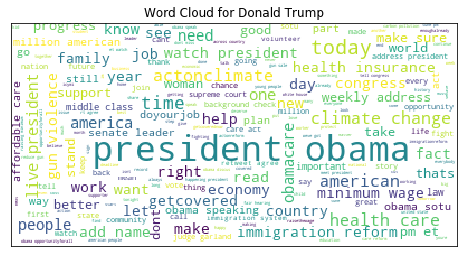

In [18]:
# Word Cloud
wc = WordCloud(background_color='white').generate(' '.join(obama_words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('Word Cloud for Donald Trump');

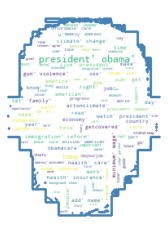

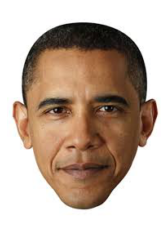

In [19]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

from wordcloud import WordCloud, STOPWORDS

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
text = str(obama_words)

# read the mask image
# taken from
# http://www.stencilry.org/stencils/movies/alice%20in%20wonderland/255fk.jpg
alice_mask = np.array(Image.open(path.join(d, "obama_bnw3.jfif")))

stopwords = set(STOPWORDS)
stopwords.add("said")

wc = WordCloud(background_color="white", max_words=2000, mask=alice_mask,
               stopwords=stopwords, contour_width=3, contour_color='steelblue')

# generate word cloud
wc.generate(text)

# store to file
wc.to_file(path.join(d, "obama_bnw_wordcloud.png"))

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

Frequent words that Obama uses: president, american, health, 

In [20]:
from gensim import corpora, models, similarities

In [21]:
import tempfile
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "C:\Users\jaymj\AppData\Local\Temp" will be used to save temporary dictionary and corpus.


In [22]:
# removing common words and tokenizing
from nltk.corpus import stopwords
from string import punctuation
list1 = ['RT','rt']
stoplist = stopwords.words('english') + list(punctuation) + list1
texts=final_obama_words
# texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]

dictionary = corpora.Dictionary(texts)
dictionary.save(os.path.join(TEMP_FOLDER, 'elon.dict'))  # store the dictionary, for future reference

#print(dictionary)
#print(dictionary.token2id)

2019-12-12 18:30:38,433 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-12-12 18:30:38,521 : INFO : built Dictionary(8388 unique tokens: ['advantage', 'asheville', 'citizen', 'consequence', 'diminished']...) from 6974 documents (total 68905 corpus positions)
2019-12-12 18:30:38,522 : INFO : saving Dictionary object under C:\Users\jaymj\AppData\Local\Temp\elon.dict, separately None
2019-12-12 18:30:38,525 : INFO : saved C:\Users\jaymj\AppData\Local\Temp\elon.dict


In [23]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize(os.path.join(TEMP_FOLDER, 'elon.mm'), corpus)

2019-12-12 18:30:38,579 : INFO : storing corpus in Matrix Market format to C:\Users\jaymj\AppData\Local\Temp\elon.mm
2019-12-12 18:30:38,580 : INFO : saving sparse matrix to C:\Users\jaymj\AppData\Local\Temp\elon.mm
2019-12-12 18:30:38,580 : INFO : PROGRESS: saving document #0
2019-12-12 18:30:38,595 : INFO : PROGRESS: saving document #1000
2019-12-12 18:30:38,607 : INFO : PROGRESS: saving document #2000
2019-12-12 18:30:38,621 : INFO : PROGRESS: saving document #3000
2019-12-12 18:30:38,634 : INFO : PROGRESS: saving document #4000
2019-12-12 18:30:38,648 : INFO : PROGRESS: saving document #5000
2019-12-12 18:30:38,662 : INFO : PROGRESS: saving document #6000
2019-12-12 18:30:38,676 : INFO : saved 6974x8388 matrix, density=0.116% (67931/58497912)
2019-12-12 18:30:38,677 : INFO : saving MmCorpus index to C:\Users\jaymj\AppData\Local\Temp\elon.mm.index


In [24]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

2019-12-12 18:30:38,681 : INFO : collecting document frequencies
2019-12-12 18:30:38,681 : INFO : PROGRESS: processing document #0
2019-12-12 18:30:38,693 : INFO : calculating IDF weights for 6974 documents and 8388 features (67931 matrix non-zeros)


In [25]:
total_topics = 4
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi
#Show first n important word in the topics:
lda.show_topics(total_topics,5)

2019-12-12 18:30:38,716 : INFO : using symmetric alpha at 0.25
2019-12-12 18:30:38,717 : INFO : using symmetric eta at 0.25
2019-12-12 18:30:38,718 : INFO : using serial LDA version on this node
2019-12-12 18:30:38,721 : INFO : running online (single-pass) LDA training, 4 topics, 1 passes over the supplied corpus of 6974 documents, updating model once every 2000 documents, evaluating perplexity every 6974 documents, iterating 50x with a convergence threshold of 0.001000
2019-12-12 18:30:38,722 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-12-12 18:30:38,722 : INFO : PROGRESS: pass 0, at document #2000/6974
2019-12-12 18:30:39,542 : INFO : merging changes from 2000 documents into a model of 6974 documents
2019-12-12 18:30:39,546 : INFO : topic #0 (0.250): 0.020*"president" + 0.016*"obama" + 0.010*"american" + 0.010*"year" + 0.008*"today" + 0.007*"read" + 0.006*"need" + 0.006*"doyourjob" + 0.006*"

[(0,
  '0.023*"president" + 0.021*"obama" + 0.019*"tax" + 0.015*"american" + 0.013*"health"'),
 (1,
  '0.061*"president" + 0.055*"obama" + 0.013*"watch" + 0.013*"job" + 0.009*"live"'),
 (2,
  '0.032*"gun" + 0.021*"congress" + 0.019*"violence" + 0.013*"president" + 0.012*"time"'),
 (3,
  '0.044*"president" + 0.044*"obama" + 0.014*"background" + 0.011*"american" + 0.009*"time"')]

In [26]:
#data_lda
from collections import OrderedDict
data_lda = {i: OrderedDict(lda.show_topic(i,25)) for i in range(total_topics)}
#data_lda
df_lda = pd.DataFrame(data_lda)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(4, 68)


In [27]:
df_lda

,act,action,actonclimate,add,affordable,agree,america,american,background,budget,care,change,check,class,climate,congress,cut,day,dont,economy,...,raisethewage,reduce,reform,right,rt,sale,sotu,speaks,support,tax,time,today,u,violence,wage,want,watch,work,would,year
0,0.008550,0.000000,0.000000,0.000000,0.006331,0.000000,0.000000,0.014676,0.000000,0.000000,0.012172,0.000000,0.006298,0.000000,0.000000,0.006445,0.00000,0.000000,0.004561,0.000000,...,0.000000,0.000000,0.005155,0.005483,0.00000,0.0000,0.000000,0.000000,0.000000,0.0186,0.005811,0.007690,0.000000,0.000000,0.000000,0.004625,0.00000,0.000000,0.000000,0.007326
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004202,0.008470,0.000000,0.005038,0.000000,0.000000,0.000000,0.004126,0.000000,0.005179,0.00000,0.003832,0.000000,0.005214,...,0.000000,0.000000,0.000000,0.004049,0.00000,0.0000,0.000000,0.003929,0.000000,0.0000,0.000000,0.000000,0.004442,0.000000,0.000000,0.004562,0.01327,0.000000,0.003872,0.003965
2,0.004985,0.006855,0.005379,0.006737,0.000000,0.008439,0.000000,0.005131,0.000000,0.000000,0.000000,0.009706,0.000000,0.000000,0.008204,0.021495,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.011137,0.000000,0.000000,0.00584,0.0072,0.000000,0.000000,0.010033,0.0000,0.011718,0.000000,0.000000,0.018537,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007961,0.010666,0.013683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007117,0.00666,0.000000,0.000000,0.004893,...,0.004547,0.000000,0.000000,0.000000,0.00000,0.0000,0.004662,0.000000,0.000000,0.0000,0.008732,0.005858,0.005032,0.000000,0.006345,0.000000,0.00000,0.005156,0.000000,0.000000


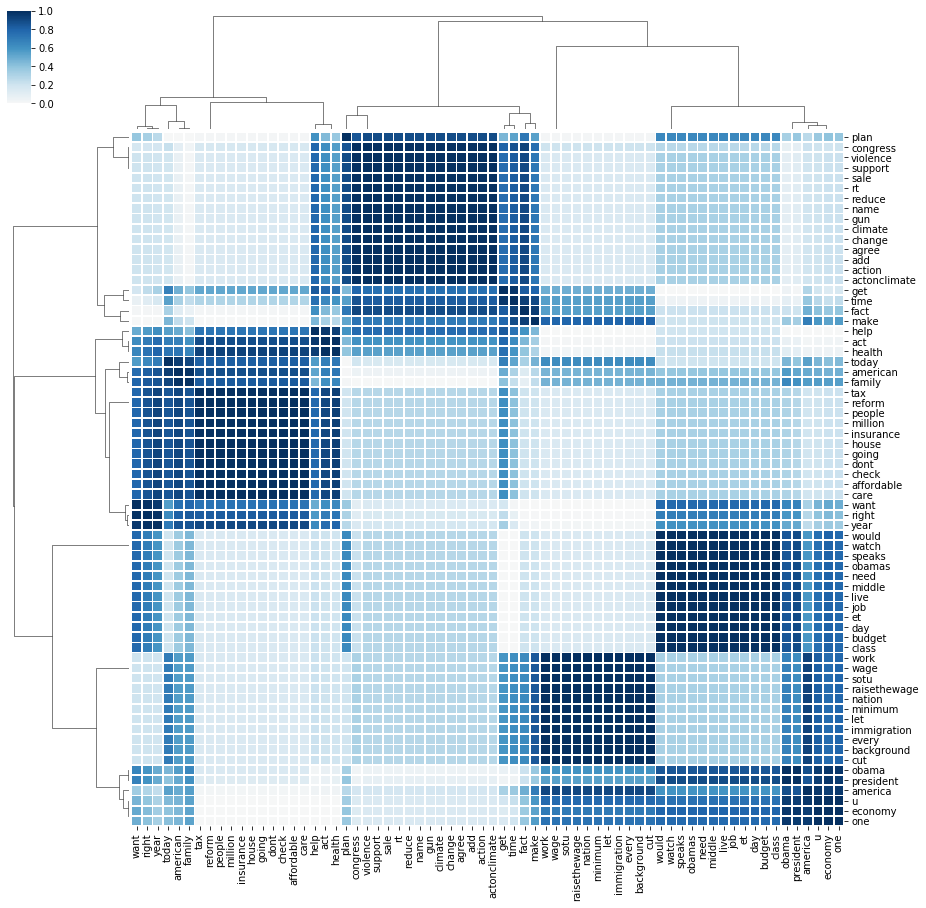

In [28]:
g=sns.clustermap(df_lda.corr(), center=0, standard_scale=1, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(15, 15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [29]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

C:\Users\jaymj\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      163.014984 -527.951416       1        1  37.176796
2      442.821747 -134.900040       2        1  37.058647
0       49.715763  144.829285       3        1  12.954767
1     -230.091507 -248.222015       4        1  12.809786, topic_info=     Category        Freq           Term       Total  loglift  logprob
99    Default  202.000000          obama  202.000000  30.0000  30.0000
250   Default  221.000000      president  221.000000  29.0000  29.0000
112   Default   85.000000            gun   85.000000  28.0000  28.0000
55    Default   48.000000       violence   48.000000  27.0000  27.0000
3615  Default   16.000000            tax   16.000000  26.0000  26.0000
1802  Default   35.000000     background   35.000000  25.0000  25.0000
1263  Default   28.000000         health   28.000000  24.0000  24.0000
122   Default   29.000000         reduce   29.000000  23.0000  23.0000
209   Default   20.000000           care   20.000000  22.0000  22.0000
1625  Default   24.000000          watch   24.000000  21.0000  21.0000
656   Default   20.000000            job   20.000000  20.0000  20.0000
58    Default   61.000000       american   61.000000  19.0000  19.0000
3693  Default   18.000000           sale   18.000000  18.0000  18.0000
992   Default   17.000000           live   17.000000  17.0000  17.0000
161   Default   13.000000      insurance   13.000000  16.0000  16.0000
240   Default   23.000000        climate   23.000000  15.0000  15.0000
45    Default   26.000000           help   26.000000  14.0000  14.0000
980   Default   27.000000            act   27.000000  13.0000  13.0000
152   Default    7.000000     affordable    7.000000  12.0000  12.0000
67    Default   30.000000        support   30.000000  11.0000  11.0000
1582  Default   13.000000         middle   13.000000  10.0000  10.0000
1953  Default   17.000000           name   17.000000   9.0000   9.0000
93    Default   22.000000           year   22.000000   8.0000   8.0000
1952  Default   18.000000            add   18.000000   7.0000   7.0000
377   Default   12.000000          right   12.000000   6.0000   6.0000
881   Default   13.000000          class   13.000000   5.0000   5.0000
51    Default   28.000000         people   28.000000   4.0000   4.0000
601   Default    8.000000          going    8.000000   3.0000   3.0000
349   Default   19.000000         action   19.000000   2.0000   2.0000
313   Default   15.000000           want   15.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
3227   Topic4    1.293797  madeinamerica    1.781612   1.7350  -6.5374
250    Topic4   54.052277      president  221.958023   0.6424  -2.8050
99     Topic4   49.009407          obama  202.503174   0.6362  -2.9030
771    Topic4    2.391494          speak    4.256164   1.4785  -5.9231
1521   Topic4    2.940753         energy    6.193267   1.3102  -5.7163
1582   Topic4    4.518677         middle   13.646459   0.9497  -5.2868
255    Topic4    1.948355         create    3.640766   1.4298  -6.1280
1398   Topic4    1.687678          voted    2.921030   1.5064  -6.2716
4032   Topic4    2.218579  comprehensive    4.820401   1.2790  -5.9981
313    Topic4    4.075762           want   15.003981   0.7517  -5.3899
164    Topic4    5.121621           need   23.732660   0.5216  -5.1615
377    Topic4    3.617121          right   12.681861   0.8005  -5.5093
881    Topic4    3.685849          class   13.641901   0.7463  -5.4905
1177   Topic4    2.804466            pas    7.999058   1.0068  -5.7638
58     Topic4    7.566573       american   61.741684  -0.0443  -4.7712
1781   Topic4    4.657543        economy   24.118797   0.4105  -5.2565
2087   Topic4    3.947223         obamas   17.886911   0.5439  -5.4220
2456   Topic4    2.814140     republican    8.494177   0.9502  -5.7603
100    Topic4    4.536518            one   29.269827   0.19

# 3. Miscellaneous Methods for Data Visualization

In [30]:
df['urls'] = df['urls'].map(eval)
df['photos'] = df['photos'].map(eval)
df['mentions'] = df['mentions'].map(eval)

In [31]:
mentions = [name.strip() for name_li in df["mentions"].values for name in (name_li)]

mentions= pd.DataFrame([mentions,[1]*len(mentions)]).T.groupby(0).count().sort_values(by=1,ascending=False)

In [32]:
mentions.drop(["barackobama"],inplace=True)
mentions.columns = ['mention_count']

In [33]:
mentions['id'] = range(1,mentions.shape[0]+1)
mentions_name = mentions.index.values
mentions_id = mentions['id'].values
mentions_count = mentions['mention_count'].values
mentions_count = mentions_count/np.sum(mentions_count)
mentions_id = [int(x) for x in mentions_id]

### 3.1 Connection Web

In [34]:
from pyvis.network import Network

mention_g = Network(height="750px", width="100%", bgcolor="#222222", font_color="white",notebook=True)
mention_g.barnes_hut()
num_vis = 20
mention_g.add_nodes(mentions_id[:num_vis] ,label=mentions_name [:num_vis])

mention_g.add_node(0,label='realobama')
for mid,w in zip(mentions_id [:num_vis] ,mentions_count[:num_vis] ):
    mention_g.add_edge(0, mid, weight=w)
mention_g.show("mention.html")

Among all the people who being mentioned by the two presidents, Obama maintains a close relationship with nytimes. It seems that New York Times share the same opinions with the two.

In [35]:
df['date'] = pd.to_datetime(df['date'])
df['period'] =df['date'].dt.to_period("Q")

prods = pd.DataFrame({'hour':range(1, 25)})

b = [0,4,8,12,16,20,24]
l = ['Late Night', 'Early Morning','Morning','Noon','Eve','Night']

In [36]:
get_hour = lambda x:int(x[:x.index(":")])
df["hour"] = df['time'].map(get_hour)

df["session"] = pd.cut(df['hour'], bins=b, labels=l)

In [37]:
keywords = ["immigrant","fake","china","america","job"]
keyword_df = df[['tweet','period','session']].copy()

for k in keywords:
    keyword_df[k] = keyword_df["tweet"].apply(lambda x:1 if k in x.lower() else 0)

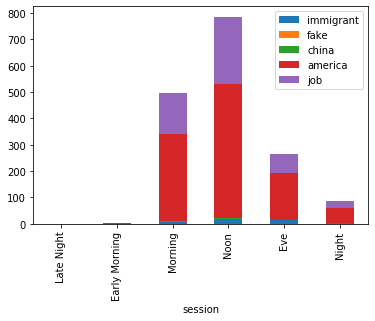

In [38]:
keyword_df.groupby("session")[keywords].sum().plot.bar(stacked=True)

Obama is self-disciplined as always and never spent unnecessary time on twitter. He never twitters at late night or on the early morning. After work, he might spend a lot of time with his family and be a good husband, a good father.

In [39]:
hot_df = df[["id","replies_count","retweets_count","likes_count","period"]].copy()
keyword_hot_df  = df[["replies_count","retweets_count","likes_count","period","tweet"]].copy()

for k in keywords:
    keyword_hot_df[k] = keyword_hot_df["tweet"].apply(lambda x:1 if k in x.lower() else 0)
    
keyword_hot_df = keyword_hot_df[keyword_hot_df[keywords].sum(axis=1)!=0]

In [40]:
kw_ht =  []
for k in keywords:
    row = keyword_hot_df[keyword_hot_df[k]==1][["replies_count","retweets_count","likes_count"]].sum(axis=0)
    row["keyword"] = k
    kw_ht.append(row)
kw_ht=  pd.DataFrame(kw_ht)

In [41]:
kw_ht.set_index("keyword",drop=True,inplace=True)

In [42]:
cols = ["replies_count","retweets_count","likes_count"]
cols.extend(keywords)
keyword_hot_df[cols]

,replies_count,retweets_count,likes_count,immigrant,fake,china,america,job
1,2099,17881,74561,0,0,0,1,0
4,1739,5277,43735,0,0,0,1,0
7,6704,34283,322797,0,0,0,1,0
13,2380,11650,46496,0,0,0,1,0
18,2585,11170,61758,0,0,0,1,0
19,3376,9076,94004,0,0,0,1,0
24,1016,3080,17126,0,0,0,1,0
26,1545,8831,57329,0,0,0,1,0
33,6152,23594,129915,0,0,0,1,0
40,15396,34163,181458,0,0,0,1,0


### 3.2 ScatterPlot for Linear Regression

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020EF06B0BE0>,
      dtype=object)

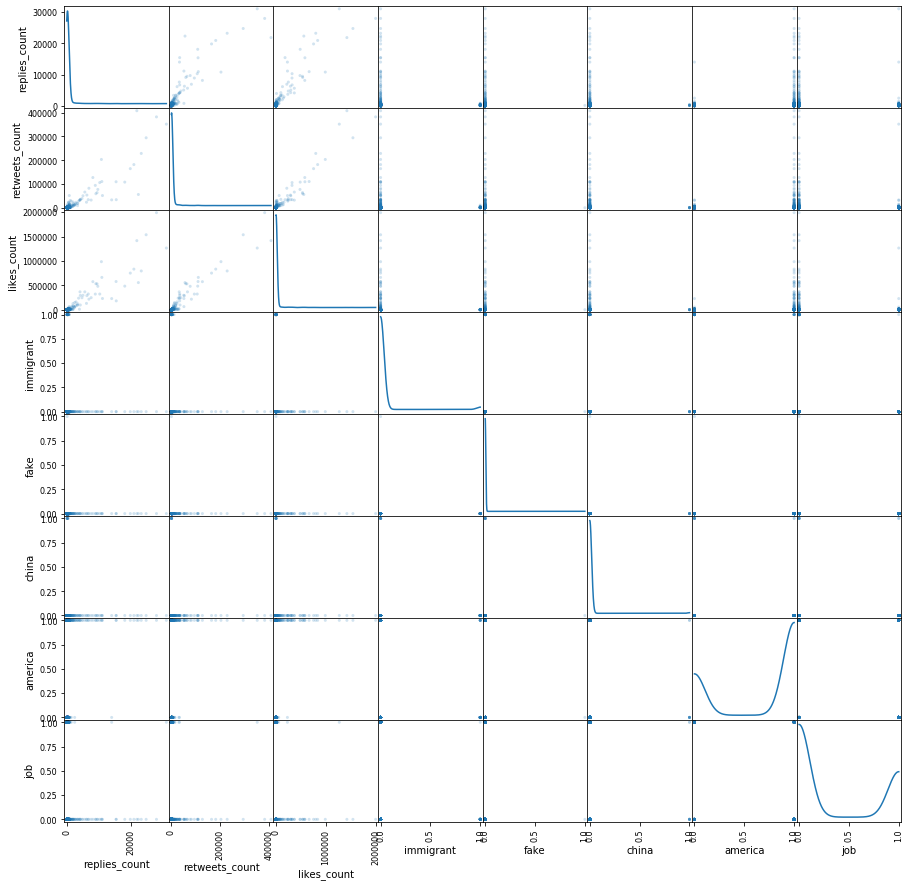

In [43]:
from pandas.plotting import scatter_matrix
scatter_matrix(keyword_hot_df[cols], alpha=0.2, figsize=(15,15), diagonal='kde')

### 3.3 Bar Chart

Text(0.5, 1.0, 'tweet type')

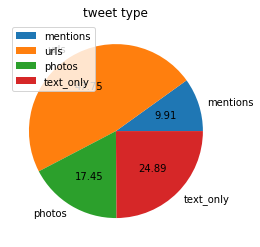

In [44]:
tweet_type = df[['period','mentions','urls','photos',]].copy()

for c in ['mentions','urls','photos']:
    tweet_type[c] = tweet_type[c].apply(lambda x:1 if len(x) >0 else 0)

tweet_type["text_only"] =tweet_type[['mentions','urls','photos']].apply(lambda x: 1 if sum(x) ==0 else 0,axis=1)

tweet_type.sum(axis=0).plot.pie(autopct="%.2f")
plt.legend()
plt.ylabel("")
plt.title("tweet type")

Obama likes to use urls most, and then text_only, photos, mentions.

### 3.4 Time Series Graph

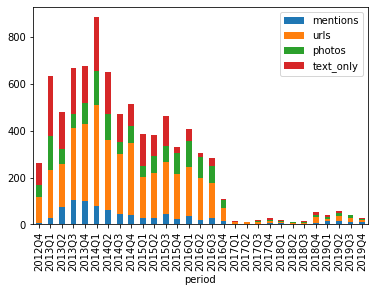

In [45]:
tt_grp = tweet_type.groupby("period")

tt_grp.sum().plot.bar(stacked=True)

Obama stayed active during his presidency and he enjoys his retire life after that. 